In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
%matplotlib inline
%config InlineBackend.figure_format='retina'
import cmocean
import cartopy.crs as ccrs
import matplotlib.path as mpath
import nc_time_axis
import pandas as pd
import matplotlib as mpl
import momlevel as ml
import gcsfs
import zarr
from matplotlib.ticker import FormatStrFormatter

In [2]:
import warnings 

def standard_grid_cell_area(lat, lon, rE=6371.0e3):
    """ computes the cell area for a standard spherical grid """

    dLat = lat[1] - lat[0]
    dLon = lon[1] - lon[0]
    area = np.empty((len(lat), len(lon)))
    for j in range(0, len(lat)):
        for i in range(0, len(lon)):
            lon1 = lon[i] + dLon / 2
            lon0 = lon[i] - dLon / 2
            lat1 = lat[j] + dLat / 2
            lat0 = lat[j] - dLat / 2
            area[j, i] = (
                (np.pi / 180.0)
                * rE
                * rE
                * np.abs(np.sin(np.radians(lat0)) - np.sin(np.radians(lat1)))
                * np.abs(lon0 - lon1)
            )
    return area

In [3]:
def south_pole_map(cols=1, rows=1, fig_size=(12,8), max_extent=-50, facecolor='white'):
    ''' 
    User note: In order to call the function, begin cell with: fig, ax = south_pole_map(**args).
    
    Neglecting "fig, ax =" at the begeinning will not map your data to the existing axes.
    
    This function sets up a polar projection centered at the South Pole, which DataArrays can be plotted over.
    
    Optional arguments accepted for figure size, maximum (northward) extent and facecolor. Any number of columns and/or rows are also accepted for multiple subplots.
    
    If creating multiple subplots, ax=ax[*index*] must be passed in the plot call for each array.
    
    By default, these are set to (12,8), -50ºS and gray, respectively. Columns/Rows set to 1 by default – specifying axes in which to plot data is not necessary when using default column number.
    '''
    import matplotlib.path as mpath
    import numpy as np
    import cartopy.crs as ccrs
    
    fig,ax = plt.subplots(figsize=fig_size, ncols=cols, nrows=rows, subplot_kw={'projection': ccrs.SouthPolarStereo(), 'facecolor':facecolor}, layout='constrained')

    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    
    if rows>1 and cols>1:
        for i in range(rows):
            for j in range(cols):
                ax[i,j].set_boundary(circle, transform=ax[i,j].transAxes)

                # lat/long map extents. shows south pole out to 50ºS
                ax[i,j].set_extent([-180, 180, -90, max_extent], ccrs.PlateCarree())
    elif cols>1 and rows==1:
        for i in range(cols):
            ax[i].set_boundary(circle, transform=ax[i].transAxes)

            # lat/long map extents. shows south pole out to 50ºS
            ax[i].set_extent([-180, 180, -90, max_extent], ccrs.PlateCarree())
    elif rows>1 and cols==1:
        for i in range(rows):
            ax[i].set_boundary(circle, transform=ax[i].transAxes)

            # lat/long map extents. shows south pole out to 50ºS
            ax[i].set_extent([-180, 180, -90, max_extent], ccrs.PlateCarree())
    else:
        ax.set_boundary(circle, transform=ax.transAxes)

            # lat/long map extents. shows south pole out to 50ºS
        ax.set_extent([-180, 180, -90, max_extent], ccrs.PlateCarree())
    
    
    #must return fig, ax when creating multiple subplots in a function
    return fig, ax

# <span style="color:red">Importing Data Sets</span>

In [4]:
mask_CM4= xr.open_dataset('/home/pachamama/shared/antarctica_mask/CM4_mask_antarctica.nc')
mask_ESM4= xr.open_dataset('/home/pachamama/shared/antarctica_mask/ESM4_mask_antarctica.nc')
mask_ERA5= xr.open_dataset('/home/pachamama/shared/antarctica_mask/ERA5_mask_antarctica.nc')

In [5]:
temperature_pi_ESM4 = xr.open_mfdataset("/backup/tuq41374/model_output/cmip6/piControl/gfdl_esm4/atmos/monthly/temp/*.nc", 
                          chunks={'time':1,'z_l':1},drop_variables=['average_DT', 'average_T1', 'average_T2'],)

temperature_pi_CM4 = xr.open_mfdataset("/backup/tuq41374/model_output/cmip6/piControl/gfdl_cm4/atmos/monthly/temp/*.nc", 
                          chunks={'time':1,'z_l':1},drop_variables=['average_DT', 'average_T1', 'average_T2'],)



In [6]:
temp_CM4 = temperature_pi_CM4.temp
temp_ESM4 = temperature_pi_ESM4.temp

In [7]:
temp_CM4

<xarray.DataArray 'temp' (time: 1140, pfull: 33, lat: 180, lon: 288)>
dask.array<concatenate, shape=(1140, 33, 180, 288), dtype=float32, chunksize=(1, 33, 180, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * pfull    (pfull) float64 2.164 5.845 10.75 17.11 ... 975.6 985.4 992.8 997.9
  * time     (time) object 0251-01-16 12:00:00 ... 0350-12-16 12:00:00
Attributes:
    long_name:      temperature
    units:          K
    valid_range:    [100. 350.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    interp_method:  conserve_order2

# <span style="color:red">Creating Seasonal Slices</span>

In [8]:
temp_climatology = ml.util.annual_cycle(temp_CM4,tcoord='time')

In [9]:
temp_seasonal = temp_CM4.groupby('time.season').mean(dim='time')
temp_summer= temp_seasonal.sel(season= 'DJF')
temp_winter=temp_seasonal.sel(season='JJA')
temp_spring=temp_seasonal.sel(season='SON')
temp_fall=temp_seasonal.sel(season='MAM')

# <span style="color:red">Applying Masks</span>

In [10]:
plateau_temp_total=(temp_ESM4*(mask_ESM4.plateau_ESM4)).mean(dim='level').mean('time')
ross_temp_total=(temp_ESM4*(mask_ESM4.ross_ESM4)).mean(dim='level').mean('time')
lowwest_temp_total=(temp_ESM4*(mask_ESM4.lowwest_ESM4)).mean(dim='level').mean('time')
loweast_temp_total=(temp_ESM4*(mask_ESM4.loweast_ESM4)).mean(dim='level').mean('time')
filchner_temp_total=(temp_ESM4*(mask_ESM4.filchner_ESM4)).mean(dim='level').mean('time')
peninsula_temp_total=(temp_ESM4*(mask_ESM4.peninsula_ESM4)).mean(dim='level').mean('time')

In [11]:
plateau_temp_summer=(temp_summer*(mask_CM4.plateau_CM4)).mean(dim='pfull')
ross_temp_summer=(temp_summer*(mask_CM4.ross_CM4)).mean(dim='pfull')
lowwest_temp_summer=(temp_summer*(mask_CM4.lowwest_CM4)).mean(dim='pfull')
loweast_temp_summer=(temp_summer*(mask_CM4.loweast_CM4)).mean(dim='pfull')
filchner_temp_summer=(temp_summer*(mask_CM4.filchner_CM4)).mean(dim='pfull')
peninsula_temp_summer=(temp_summer*(mask_CM4.peninsula_CM4)).mean(dim='pfull')

In [12]:
plateau_temp_winter=(temp_winter*(mask_CM4.plateau_CM4)).mean(dim='pfull')
ross_temp_winter=(temp_winter*(mask_CM4.ross_CM4)).mean(dim='pfull')
lowwest_temp_winter=(temp_winter*(mask_CM4.lowwest_CM4)).mean(dim='pfull')
loweast_temp_winter=(temp_winter*(mask_CM4.loweast_CM4)).mean(dim='pfull')
filchner_temp_winter=(temp_winter*(mask_CM4.filchner_CM4)).mean(dim='pfull')
peninsula_temp_winter=(temp_winter*(mask_CM4.peninsula_CM4)).mean(dim='pfull')

In [13]:
plateau_temp_spring=(temp_spring*(mask_CM4.plateau_CM4)).mean(dim='pfull')
ross_temp_spring=(temp_spring*(mask_CM4.ross_CM4)).mean(dim='pfull')
lowwest_temp_spring=(temp_spring*(mask_CM4.lowwest_CM4)).mean(dim='pfull')
loweast_temp_spring=(temp_spring*(mask_CM4.loweast_CM4)).mean(dim='pfull')
filchner_temp_spring=(temp_spring*(mask_CM4.filchner_CM4)).mean(dim='pfull')
peninsula_temp_spring=(temp_spring*(mask_CM4.peninsula_CM4)).mean(dim='pfull')

In [14]:
plateau_temp_fall=(temp_fall*(mask_CM4.plateau_CM4)).mean(dim='pfull')
ross_temp_fall=(temp_spring*(mask_CM4.ross_CM4)).mean(dim='pfull')
lowwest_temp_fall=(temp_fall*(mask_CM4.lowwest_CM4)).mean(dim='pfull')
loweast_temp_fall=(temp_fall*(mask_CM4.loweast_CM4)).mean(dim='pfull')
filchner_temp_fall=(temp_fall*(mask_CM4.filchner_CM4)).mean(dim='pfull')
peninsula_temp_fall=(temp_fall*(mask_CM4.peninsula_CM4)).mean(dim='pfull')

# <span style="color:red">Total Temp Plot</span>

In [ ]:
fig, ax = south_pole_map(cols=3, rows=3,fig_size=(20,17))


plateau_temp_total.plot(ax=ax[0,0],
              transform =ccrs.PlateCarree(),
        
              extend='both',
              cmap=cmocean.cm.thermal)
    
ross_temp_total.plot(ax=ax[0,1],
              transform =ccrs.PlateCarree(),
             
              extend='both',
              cmap=cmocean.cm.thermal)
lowwest_temp_total.plot(ax=ax[0,2],
               transform =ccrs.PlateCarree(),
               
               extend='both',
               cmap=cmocean.cm.thermal)
    
loweast_temp_total.plot(ax=ax[1,0],
            transform =ccrs.PlateCarree(),
              
               extend='both',
               cmap= cmocean.cm.thermal)
peninsula_temp_total.plot(ax=ax[1,1],
              transform =ccrs.PlateCarree(),
              
              extend='both',
              cmap=cmocean.cm.thermal)
filchner_temp_total.plot(ax=ax[1,2],
              transform =ccrs.PlateCarree(),
              
              extend='both',
              cmap=cmocean.cm.balance)
temp_CM4.mean('time').mean('pfull').plot(ax=ax[2,0],
               transform =ccrs.PlateCarree(),
               vmin=220,
                vmax=240,
               extend='both',
               cmap=cmocean.cm.thermal)

# ross_temp_total.plot(ax=ax[2,0],
#                transform =ccrs.PlateCarree(),
#                extend='both',
              
#                cmap=cmocean.cm.balance, add_colorbar=False)


# lowwest_temp_total.plot(ax=ax[2,0],
#                transform =ccrs.PlateCarree(),
#                extend='both',
              
#                cmap=cmocean.cm.balance, add_colorbar=False)

# loweast_temp_total.plot(ax=ax[2,0],
#                transform =ccrs.PlateCarree(),
#                extend='both',
               
#                cmap=cmocean.cm.balance, add_colorbar=False)

# filchner_temp_total.plot(ax=ax[2,0],
#                transform =ccrs.PlateCarree(),
#                extend='both',
                
#                cmap=cmocean.cm.balance, add_colorbar=False)

# peninsula_temp_total.plot(ax=ax[2,0],
#                transform =ccrs.PlateCarree(),
#                extend='both',
               
#                cmap=cmocean.cm.balance, add_colorbar=False)



ax[0,0].coastlines()
ax[0,1].coastlines()
ax[0,2].coastlines()
ax[1,0].coastlines()
ax[1,1].coastlines()
ax[1,2].coastlines()
ax[2,0].coastlines()

ax[0,0].set_title('Plateau',size=15)
ax[0,1].set_title('Ross',size=15)
ax[0,2].set_title('Low West',size=15)
ax[1,0].set_title('Low East',size=15)
ax[1,1].set_title('Peninsula',size=15)
ax[1,2].set_title('Filchner',size=15)
ax[2,0].set_title('All Regions',size=15)


fig.suptitle('Temperature (Kelvin)', fontsize=20)

# <span style="color:red">Fall Temp Plot</span>

Text(0.5, 0.98, 'Temperature (Kelvin) for Fall (MAM)')

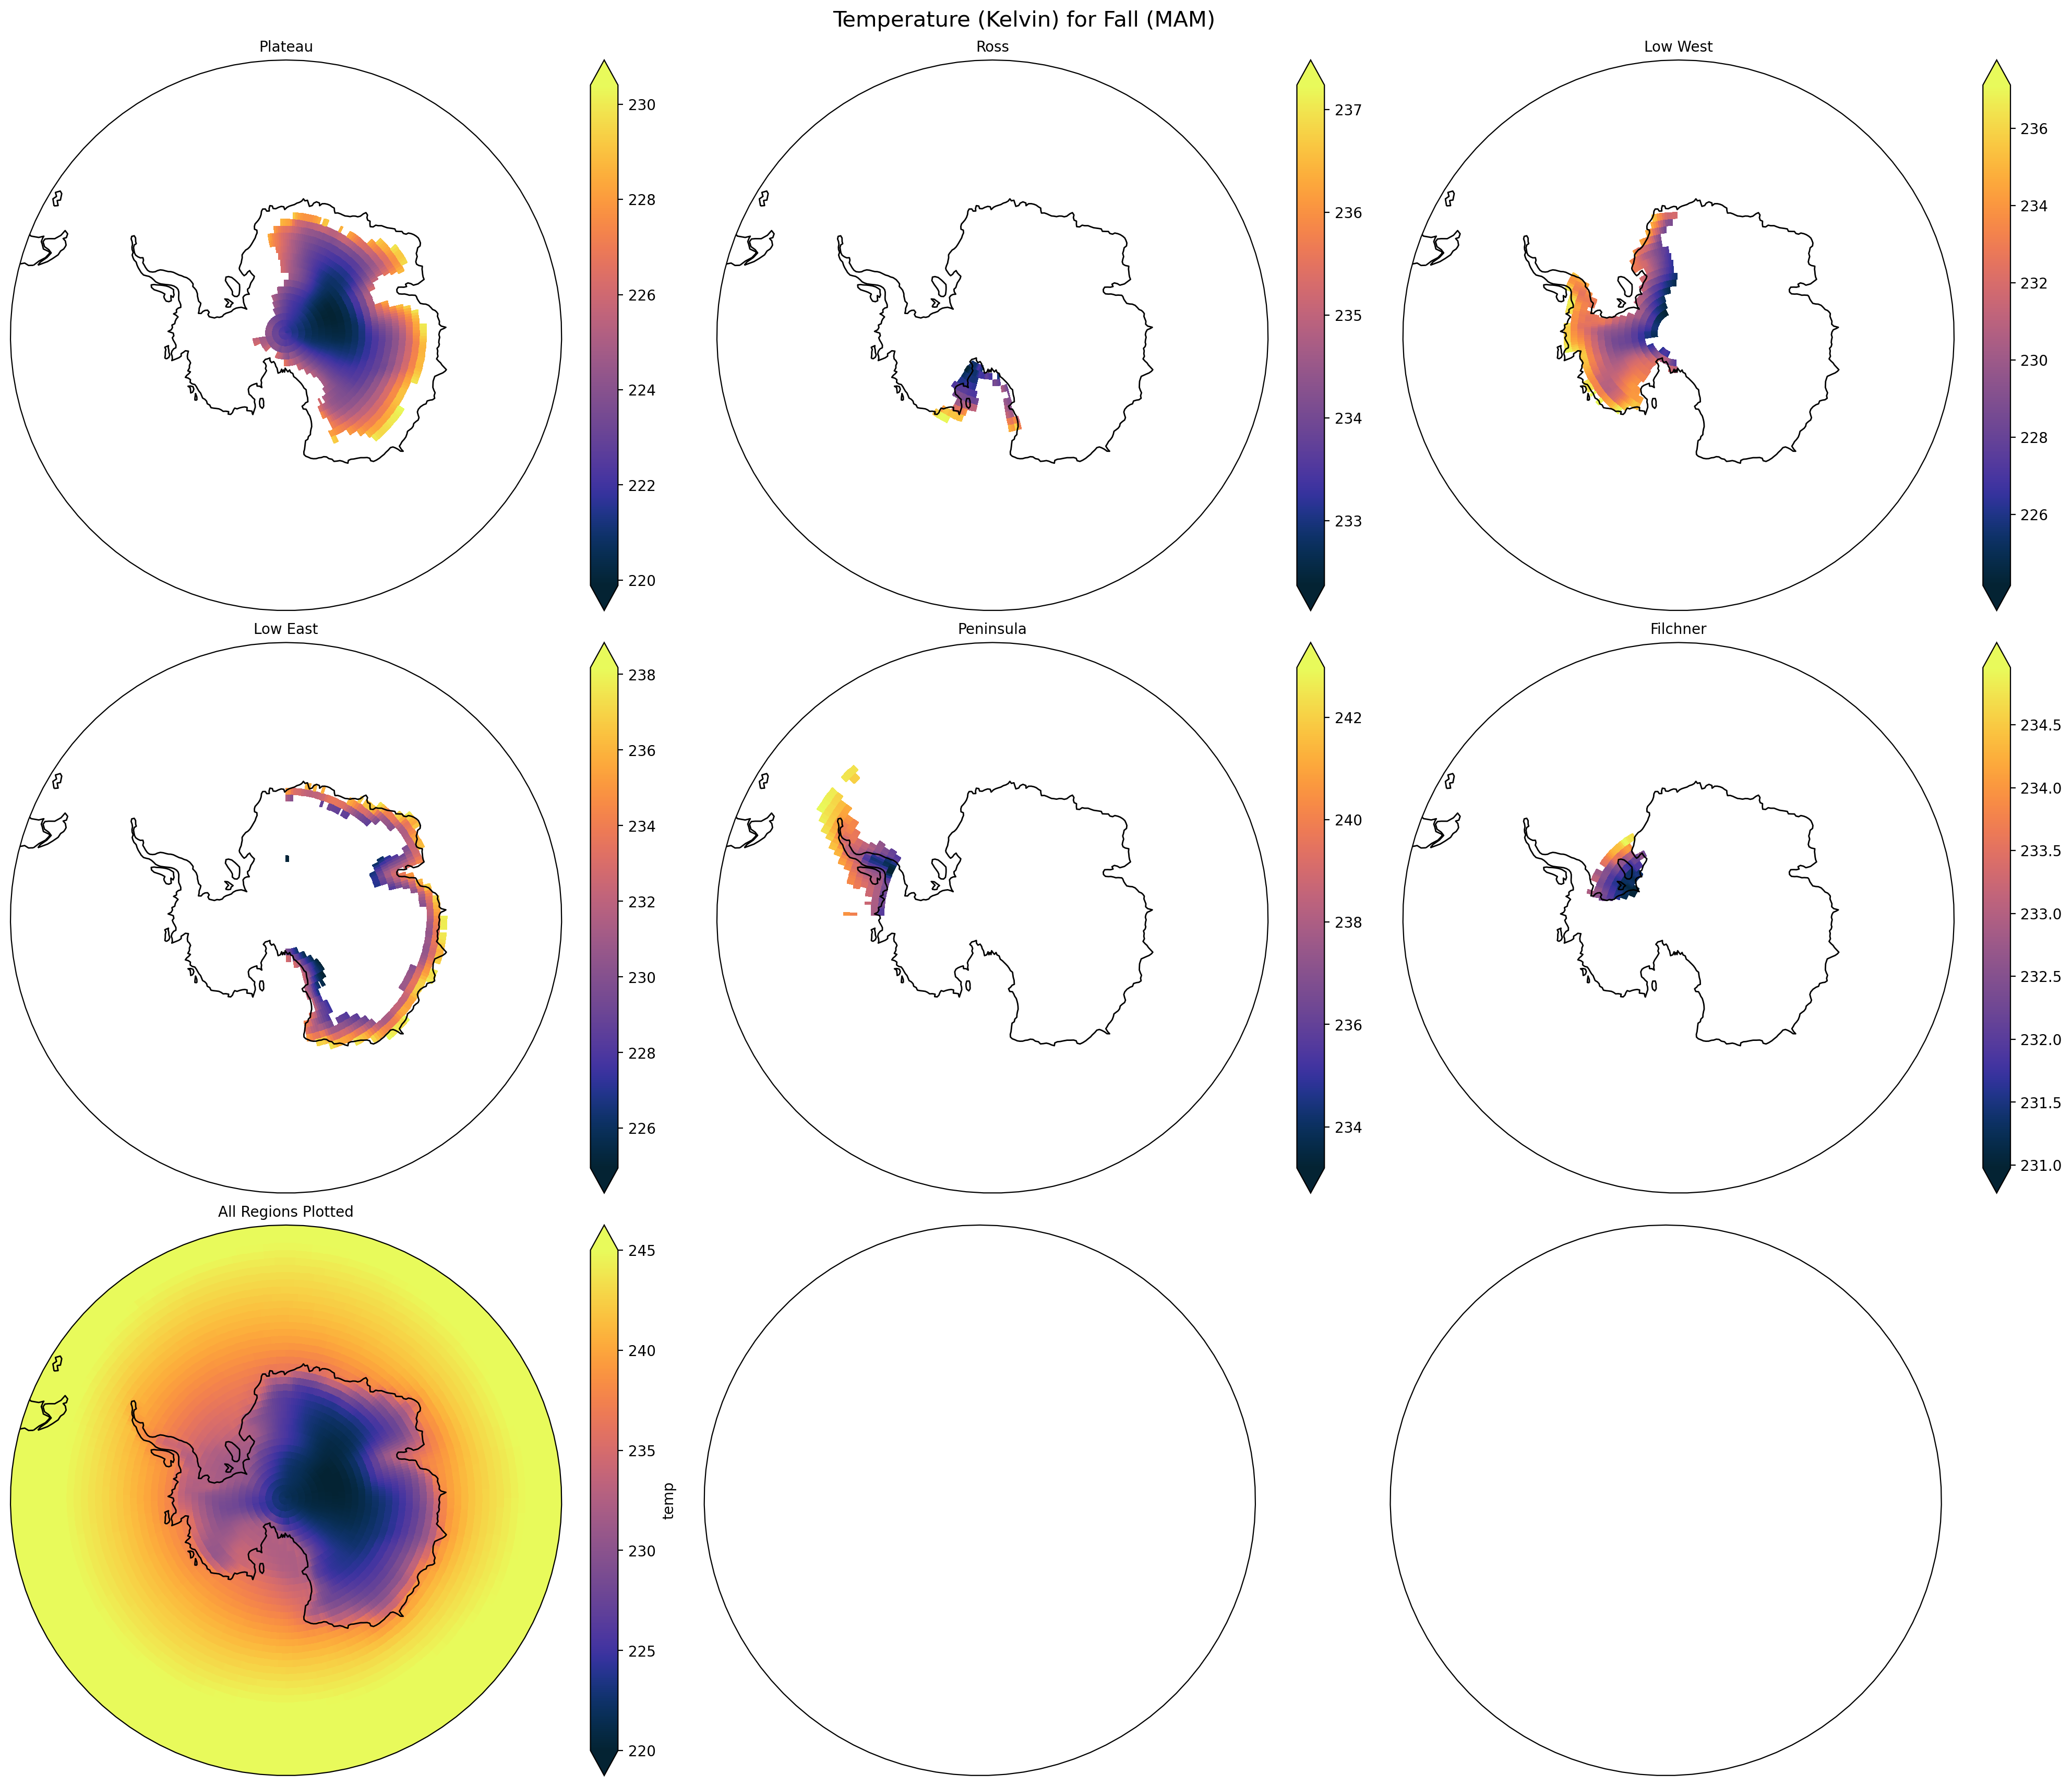

In [27]:
fig, ax = south_pole_map(cols=3, rows=3,fig_size=(20,17))


plateau_temp_fall.plot(ax=ax[0,0],
              transform =ccrs.PlateCarree(),
              
              extend='both',
              cmap=cmocean.cm.thermal)
    
ross_temp_fall.plot(ax=ax[0,1],
              transform =ccrs.PlateCarree(),
             
              extend='both',
              cmap=cmocean.cm.thermal)
lowwest_temp_fall.plot(ax=ax[0,2],
               transform =ccrs.PlateCarree(),
               
               extend='both',
               cmap=cmocean.cm.thermal)
    
loweast_temp_fall.plot(ax=ax[1,0],
            transform =ccrs.PlateCarree(),
              
               extend='both',
               cmap= cmocean.cm.thermal)
peninsula_temp_fall.plot(ax=ax[1,1],
              transform =ccrs.PlateCarree(),
              
              extend='both',
              cmap=cmocean.cm.thermal)
filchner_temp_fall.plot(ax=ax[1,2],
              transform =ccrs.PlateCarree(),
              
              extend='both',
              cmap=cmocean.cm.thermal)
temp_fall.mean('pfull').plot(ax=ax[2,0],
               transform =ccrs.PlateCarree(),
               vmin=220,
               vmax= 245,
               extend='both',
               cmap=cmocean.cm.thermal)

# ross_temp_fall.plot(ax=ax[0,3],
#                transform =ccrs.PlateCarree(),
#                extend='both',
              
#                cmap=cmocean.cm.balance, add_colorbar=False)


# lowwest_temp_fall.plot(ax=ax[0,3],
#                transform =ccrs.PlateCarree(),
#                extend='both',
              
#                cmap=cmocean.cm.balance, add_colorbar=False)

# loweast_temp_fall.plot(ax=ax[0,3],
#                transform =ccrs.PlateCarree(),
#                extend='both',
               
#                cmap=cmocean.cm.balance, add_colorbar=False)

# filchner_temp_fall.plot(ax=ax[0,3],
#                transform =ccrs.PlateCarree(),
#                extend='both',
                
#                cmap=cmocean.cm.balance, add_colorbar=False)

# peninsula_temp_fall.plot(ax=ax[0,3],
#                transform =ccrs.PlateCarree(),
#                extend='both',
               
#                cmap=cmocean.cm.balance, add_colorbar=False)



ax[0,0].coastlines()
ax[0,1].coastlines()
ax[0,2].coastlines()
ax[1,0].coastlines()
ax[1,1].coastlines()
ax[1,2].coastlines()
ax[2,0].coastlines()

ax[0,0].set_title('Plateau',size=10)
ax[0,1].set_title('Ross',size=10)
ax[0,2].set_title('Low West',size=10)
ax[1,0].set_title('Low East',size=10)
ax[1,1].set_title('Peninsula',size=10)
ax[1,2].set_title('Filchner',size=10)
ax[2,0].set_title('All Regions Plotted',size=10)


fig.suptitle('Temperature (Kelvin) for Fall (MAM)', fontsize=15)

# <span style="color:red">Spring Temp Plot</span>

Text(0.5, 0.98, 'Temperature (Kelvin) for Spring (SON)')

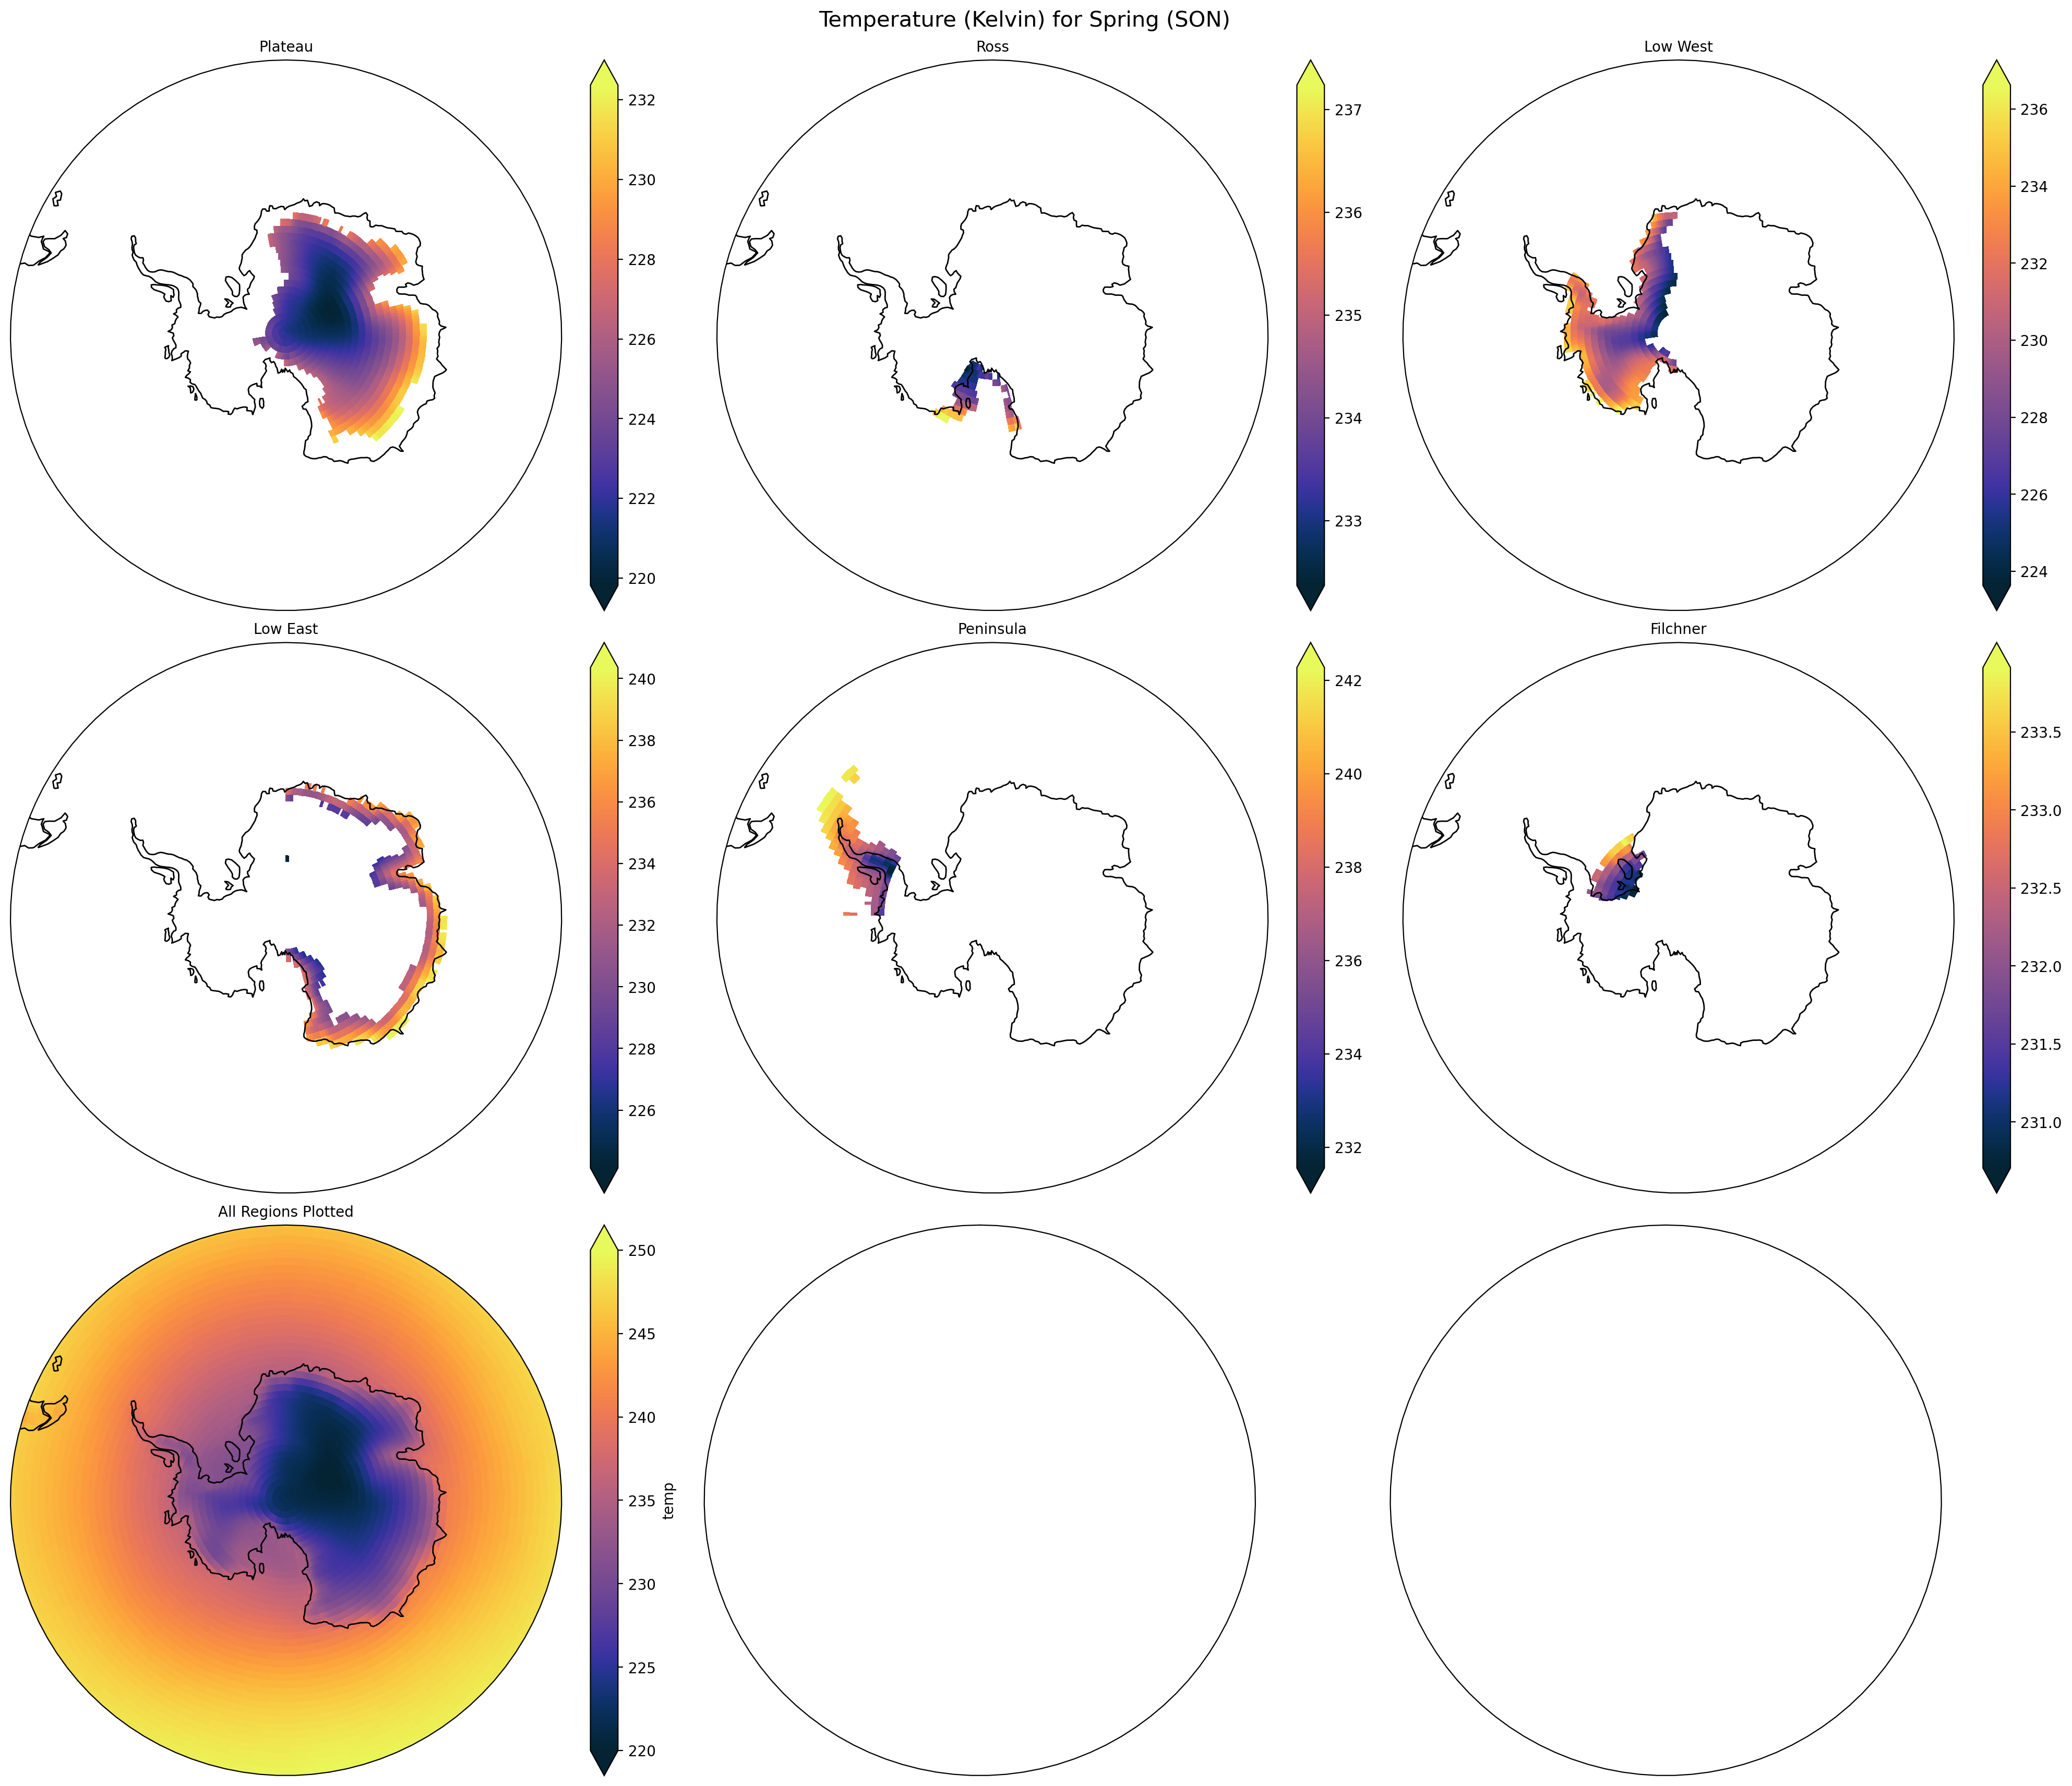

In [26]:
fig, ax = south_pole_map(cols=3, rows=3,fig_size=(20,17))


plateau_temp_spring.plot(ax=ax[0,0],
              transform =ccrs.PlateCarree(),
              
              extend='both',
              cmap=cmocean.cm.thermal)
    
ross_temp_spring.plot(ax=ax[0,1],
              transform =ccrs.PlateCarree(),
             
              extend='both',
              cmap=cmocean.cm.thermal)
lowwest_temp_spring.plot(ax=ax[0,2],
               transform =ccrs.PlateCarree(),
               
               extend='both',
               cmap=cmocean.cm.thermal)
    
loweast_temp_spring.plot(ax=ax[1,0],
            transform =ccrs.PlateCarree(),
              
               extend='both',
               cmap= cmocean.cm.thermal)
peninsula_temp_spring.plot(ax=ax[1,1],
              transform =ccrs.PlateCarree(),
              
              extend='both',
              cmap=cmocean.cm.thermal)
filchner_temp_spring.plot(ax=ax[1,2],
              transform =ccrs.PlateCarree(),
              
              extend='both',
              cmap=cmocean.cm.thermal)
temp_spring.mean('pfull').plot(ax=ax[2,0],
               transform =ccrs.PlateCarree(),
               vmin=220,
               vmax=250,
               extend='both',
               cmap=cmocean.cm.thermal)

# ross_temp_spring.plot(ax=ax[0,3],
#                transform =ccrs.PlateCarree(),
#                extend='both',
              
#                cmap=cmocean.cm.balance, add_colorbar=False)


# lowwest_temp_spring.plot(ax=ax[0,3],
#                transform =ccrs.PlateCarree(),
#                extend='both',
              
#                cmap=cmocean.cm.balance, add_colorbar=False)

# loweast_temp_spring.plot(ax=ax[0,3],
#                transform =ccrs.PlateCarree(),
#                extend='both',
               
#                cmap=cmocean.cm.balance, add_colorbar=False)

# filchner_temp_spring.plot(ax=ax[0,3],
#                transform =ccrs.PlateCarree(),
#                extend='both',
                
#                cmap=cmocean.cm.balance, add_colorbar=False)

# peninsula_temp_spring.plot(ax=ax[0,3],
#                transform =ccrs.PlateCarree(),
#                extend='both',
               
#                cmap=cmocean.cm.balance, add_colorbar=False)



ax[0,0].coastlines()
ax[0,1].coastlines()
ax[0,2].coastlines()
ax[1,0].coastlines()
ax[1,1].coastlines()
ax[1,2].coastlines()
ax[2,0].coastlines()

ax[0,0].set_title('Plateau',size=10)
ax[0,1].set_title('Ross',size=10)
ax[0,2].set_title('Low West',size=10)
ax[1,0].set_title('Low East',size=10)
ax[1,1].set_title('Peninsula',size=10)
ax[1,2].set_title('Filchner',size=10)
ax[2,0].set_title('All Regions Plotted',size=10)


fig.suptitle('Temperature (Kelvin) for Spring (SON)', fontsize=15)

# <span style="color:red">Summer Temp Plot</span>

Text(0.5, 0.98, 'Temperature (Kelvin) for Summer (DJF)')

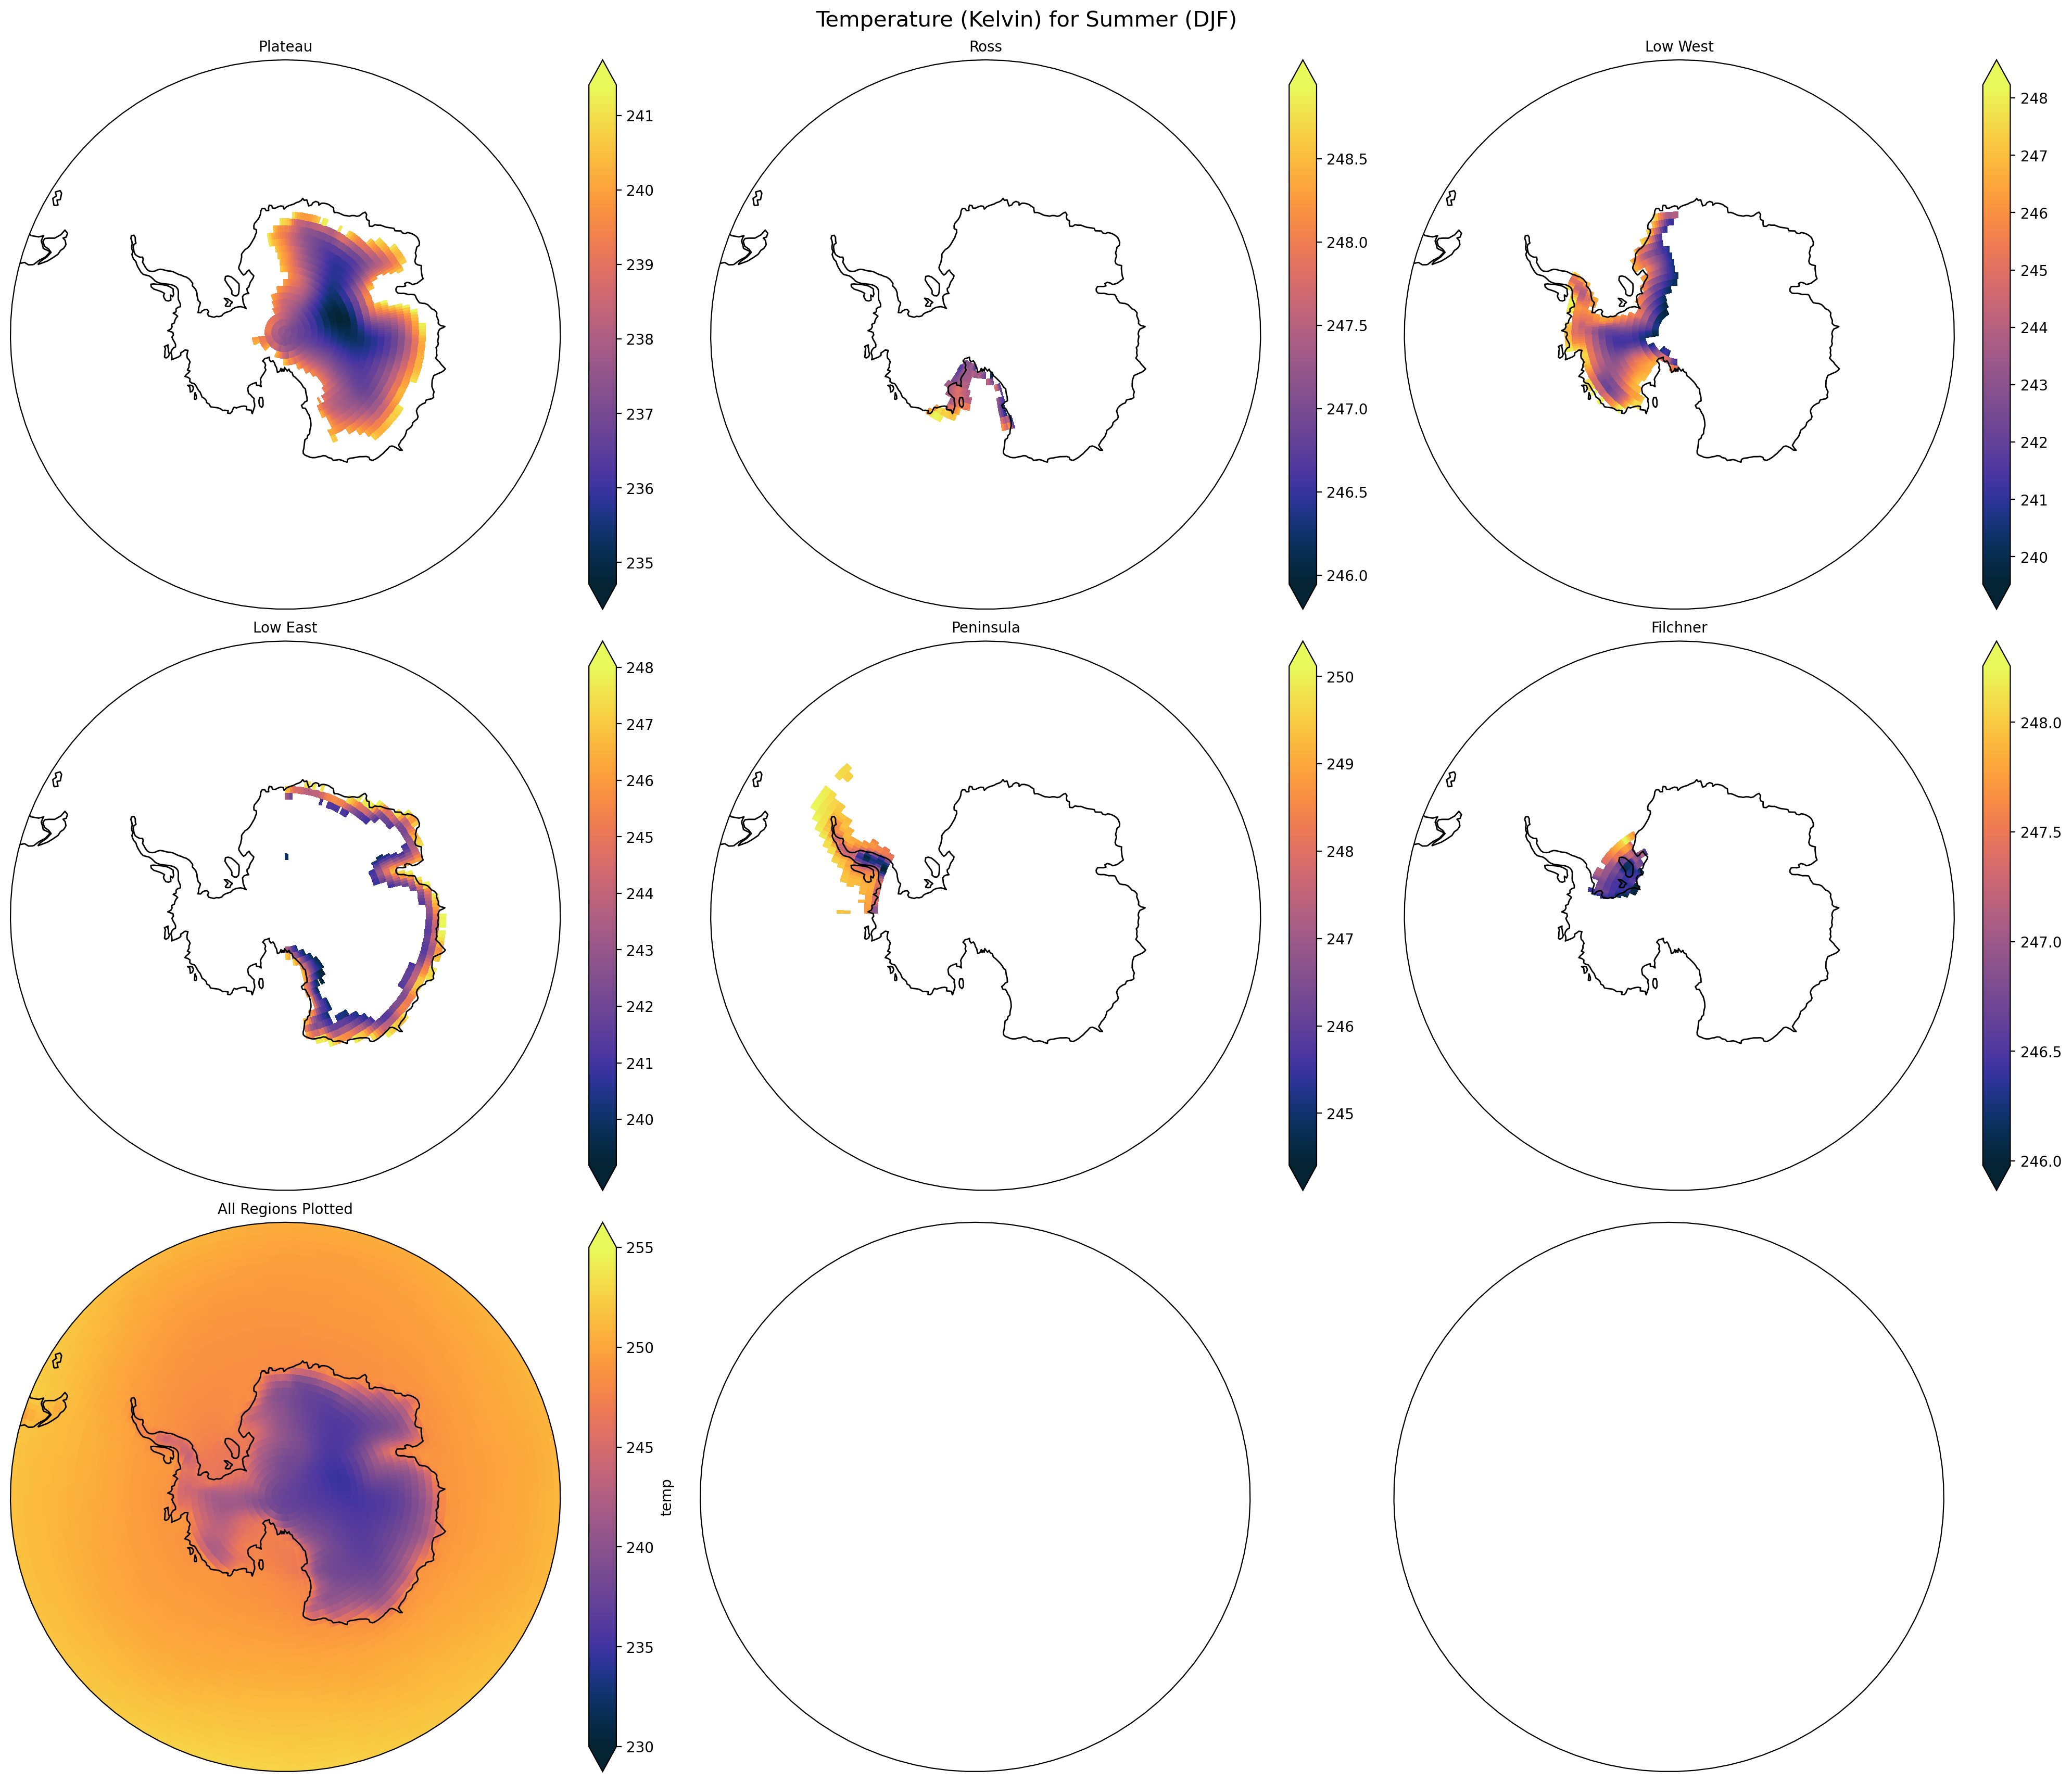

In [24]:
fig, ax = south_pole_map(cols=3, rows=3,fig_size=(20,17))


plateau_temp_summer.plot(ax=ax[0,0],
              transform =ccrs.PlateCarree(),
              
              extend='both',
              cmap=cmocean.cm.thermal)
    
ross_temp_summer.plot(ax=ax[0,1],
              transform =ccrs.PlateCarree(),
             
              extend='both',
              cmap=cmocean.cm.thermal)
lowwest_temp_summer.plot(ax=ax[0,2],
               transform =ccrs.PlateCarree(),
               
               extend='both',
               cmap=cmocean.cm.thermal)
    
loweast_temp_summer.plot(ax=ax[1,0],
            transform =ccrs.PlateCarree(),
              
               extend='both',
               cmap= cmocean.cm.thermal)
peninsula_temp_summer.plot(ax=ax[1,1],
              transform =ccrs.PlateCarree(),
              
              extend='both',
              cmap=cmocean.cm.thermal)
filchner_temp_summer.plot(ax=ax[1,2],
              transform =ccrs.PlateCarree(),
              
              extend='both',
              cmap=cmocean.cm.thermal)
temp_summer.mean('pfull').plot(ax=ax[2,0],
               transform =ccrs.PlateCarree(),
               vmin=230,
                vmax=255,
                
               extend='both',
               cmap=cmocean.cm.thermal)

# ross_temp_summer.plot(ax=ax[0,3],
#                transform =ccrs.PlateCarree(),
#                extend='both',
              
#                cmap=cmocean.cm.balance, add_colorbar=False)


# lowwest_temp_summer.plot(ax=ax[0,3],
#                transform =ccrs.PlateCarree(),
#                extend='both',
              
#                cmap=cmocean.cm.balance, add_colorbar=False)

# loweast_temp_summer.plot(ax=ax[0,3],
#                transform =ccrs.PlateCarree(),
#                extend='both',
               
#                cmap=cmocean.cm.balance, add_colorbar=False)

# filchner_temp_summer.plot(ax=ax[0,3],
#                transform =ccrs.PlateCarree(),
#                extend='both',
                
#                cmap=cmocean.cm.balance, add_colorbar=False)

# peninsula_temp_summer.plot(ax=ax[0,3],
#                transform =ccrs.PlateCarree(),
#                extend='both',
               
#                cmap=cmocean.cm.balance, add_colorbar=False)



ax[0,0].coastlines()
ax[0,1].coastlines()
ax[0,2].coastlines()
ax[1,0].coastlines()
ax[1,1].coastlines()
ax[1,2].coastlines()
ax[2,0].coastlines()

ax[0,0].set_title('Plateau',size=10)
ax[0,1].set_title('Ross',size=10)
ax[0,2].set_title('Low West',size=10)
ax[1,0].set_title('Low East',size=10)
ax[1,1].set_title('Peninsula',size=10)
ax[1,2].set_title('Filchner',size=10)
ax[2,0].set_title('All Regions Plotted',size=10)


fig.suptitle('Temperature (Kelvin) for Summer (DJF)', fontsize=15)

# <span style="color:red">Winter Temp Plot</span>

Text(0.5, 0.98, 'Temperature (Kelvin) for Winter (JJA)')

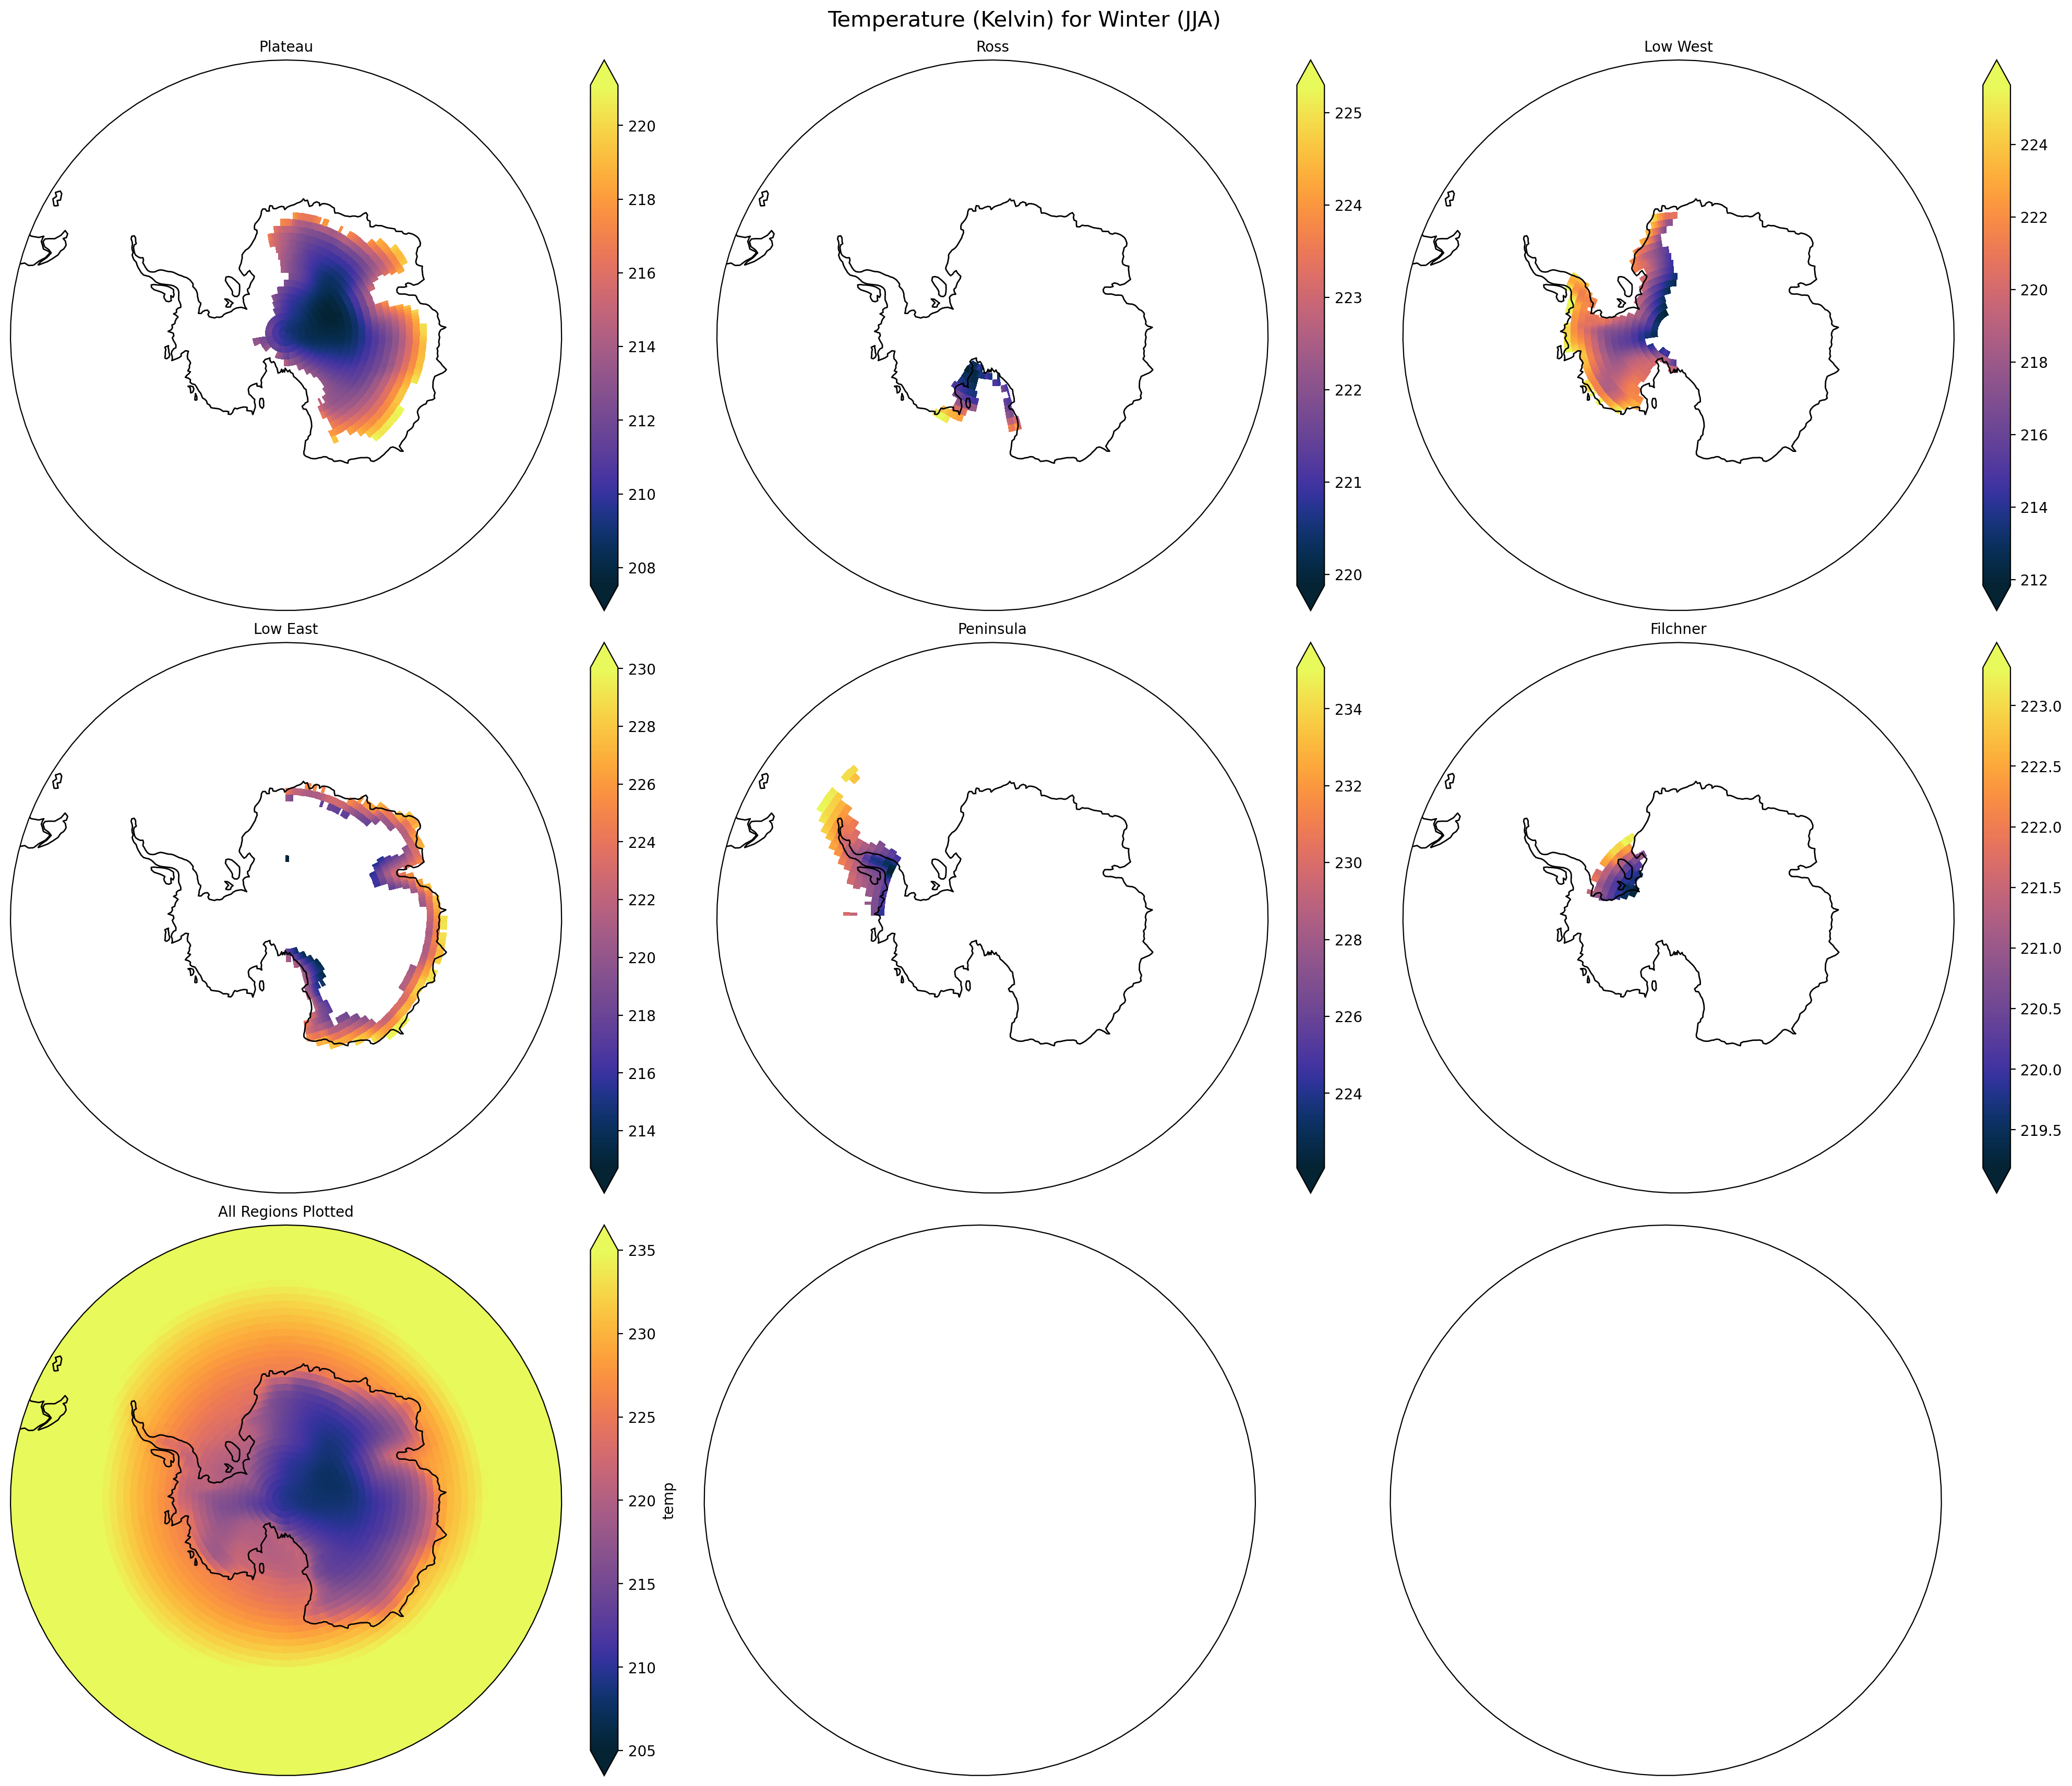

In [28]:
fig, ax = south_pole_map(cols=3, rows=3,fig_size=(20,17))


plateau_temp_winter.plot(ax=ax[0,0],
              transform =ccrs.PlateCarree(),
              
              extend='both',
              cmap=cmocean.cm.thermal)
    
ross_temp_winter.plot(ax=ax[0,1],
              transform =ccrs.PlateCarree(),
             
              extend='both',
              cmap=cmocean.cm.thermal)
lowwest_temp_winter.plot(ax=ax[0,2],
               transform =ccrs.PlateCarree(),
               
               extend='both',
               cmap=cmocean.cm.thermal)
    
loweast_temp_winter.plot(ax=ax[1,0],
            transform =ccrs.PlateCarree(),
              
               extend='both',
               cmap= cmocean.cm.thermal)
peninsula_temp_winter.plot(ax=ax[1,1],
              transform =ccrs.PlateCarree(),
              
              extend='both',
              cmap=cmocean.cm.thermal)
filchner_temp_winter.plot(ax=ax[1,2],
              transform =ccrs.PlateCarree(),
              
              extend='both',
              cmap=cmocean.cm.thermal)
# plateau_temp_winter.plot(ax=ax[0,3],
#                transform =ccrs.PlateCarree(),
               
#                extend='both',
#                cmap=cmocean.cm.balance, add_colorbar=False)

temp_winter.mean('pfull').plot(ax=ax[2,0],
               transform =ccrs.PlateCarree(),
               extend='both',
                vmin=205,
                vmax=235,
              
               cmap=cmocean.cm.thermal)


# lowwest_temp_winter.plot(ax=ax[0,3],
#                transform =ccrs.PlateCarree(),
#                extend='both',
              
#                cmap=cmocean.cm.balance, add_colorbar=False)

# loweast_temp_winter.plot(ax=ax[0,3],
#                transform =ccrs.PlateCarree(),
#                extend='both',
               
#                cmap=cmocean.cm.balance, add_colorbar=False)

# filchner_temp_winter.plot(ax=ax[0,3],
#                transform =ccrs.PlateCarree(),
#                extend='both',
                
#                cmap=cmocean.cm.balance, add_colorbar=False)

# peninsula_temp_winter.plot(ax=ax[0,3],
#                transform =ccrs.PlateCarree(),
#                extend='both',
               
#                cmap=cmocean.cm.balance, add_colorbar=False)



ax[0,0].coastlines()
ax[0,1].coastlines()
ax[0,2].coastlines()
ax[1,0].coastlines()
ax[1,1].coastlines()
ax[1,2].coastlines()
ax[2,0].coastlines()

ax[0,0].set_title('Plateau',size=10)
ax[0,1].set_title('Ross',size=10)
ax[0,2].set_title('Low West',size=10)
ax[1,0].set_title('Low East',size=10)
ax[1,1].set_title('Peninsula',size=10)
ax[1,2].set_title('Filchner',size=10)
ax[2,0].set_title('All Regions Plotted',size=10)


fig.suptitle('Temperature (Kelvin) for Winter (JJA)', fontsize=15)

In [22]:

lat_temp = temperature_pi_CM4.coords['lat'].values #1-D numpy array of model's latitude values
lon_temp =temperature_pi_CM4.coords['lon'].values #1-D numpy array of model's longitude values

# make sure to replace the name of the data array if you chose a 
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.

# Pass the arrays to the standard_grid_cell_area function
areacell = standard_grid_cell_area(lat_temp,lon_temp)  

# The areacella_xarray function outputs a numpy array. Convert this back into 
# and xarray DataArray for further use. If this is a field you will be using 
# often. You may wish to save this newly created DataArray as a Dataset and save 
# as a netcdf file.

# here we assign dimensions and coordinates that are the same as our original SST array:

areacell_xarray = xr.DataArray(areacell,dims=({'lat':180, 'lon':360}),\
                                                coords=(temp_CM4.coords['lat'],\
                                                        temp_CM4.coords['lon']))

Text(0.5, 1.0, 'Atmosphere Grid Cell Area')

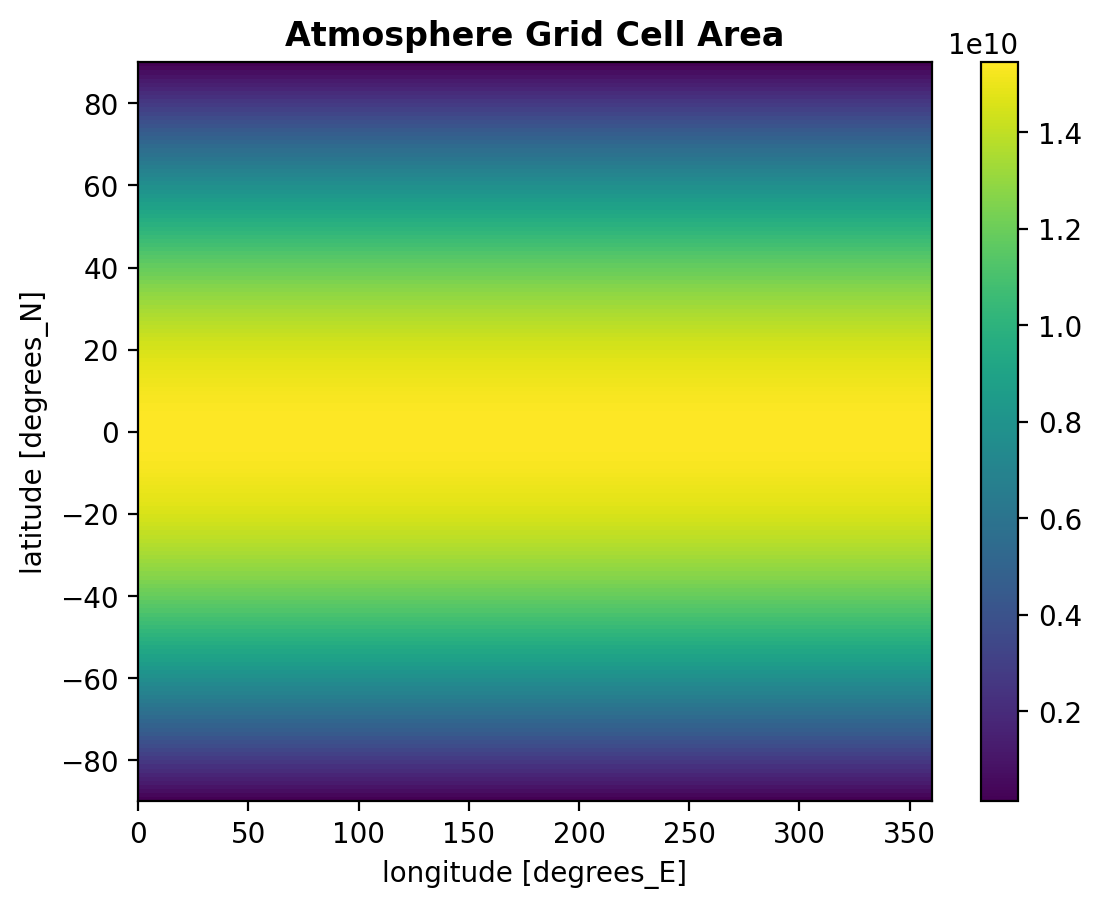

In [23]:
areacell_xarray.plot()
plt.title('Atmosphere Grid Cell Area', fontweight='bold')

In [73]:

plateau_temp_weight=areacell_xarray*mask_CM4.plateau_CM4
ross_temp_weight=areacell_xarray*mask_CM4.ross_CM4
lowwest_temp_weight=areacell_xarray*mask_CM4.lowwest_CM4
loweast_temp_weight=areacell_xarray*mask_CM4.loweast_CM4
filchner_temp_weight=areacell_xarray*mask_CM4.filchner_CM4
peninsula_temp_weight=areacell_xarray*mask_CM4.peninsula_CM4

In [74]:
plateau_weighted_average_temp = temp_CM4.weighted(plateau_temp_weight.fillna(0)).mean('pfull').mean('time')
ross_weighted_average_temp= temp_CM4.weighted(ross_temp_weight.fillna(0)).mean('pfull').mean('time')
lowwest_weighted_average_temp= temp_CM4.weighted(lowwest_temp_weight.fillna(0)).mean('pfull').mean('time')
loweast_weighted_average_temp= temp_CM4.weighted(loweast_temp_weight.fillna(0)).mean('pfull').mean('time')
filchner_weighted_average_temp= temp_CM4.weighted(filchner_temp_weight.fillna(0)).mean('pfull').mean('time')
peninsula_weighted_average_temp= temp_CM4.weighted(peninsula_temp_weight.fillna(0)).mean('pfull').mean('time')

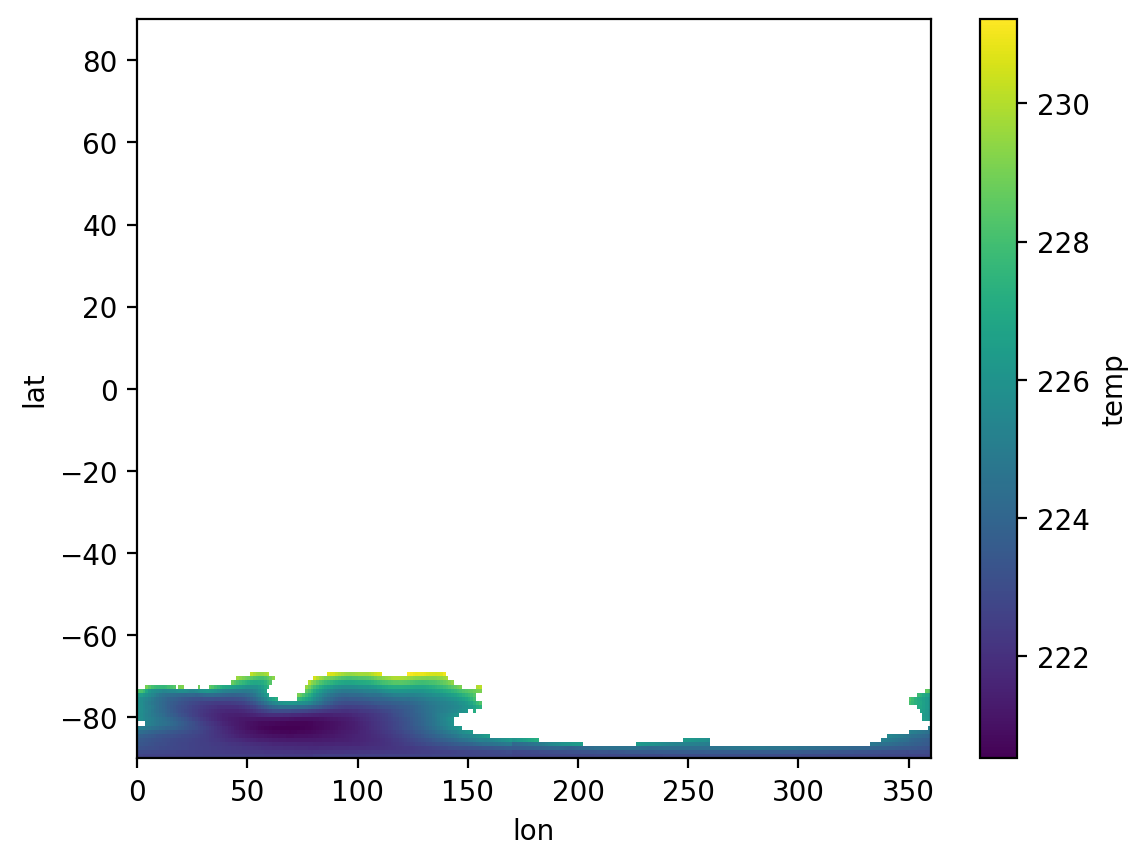

In [68]:
plateau_weighted_average_temp.plot()

Text(0.5, 1.0, 'Nonweighted')

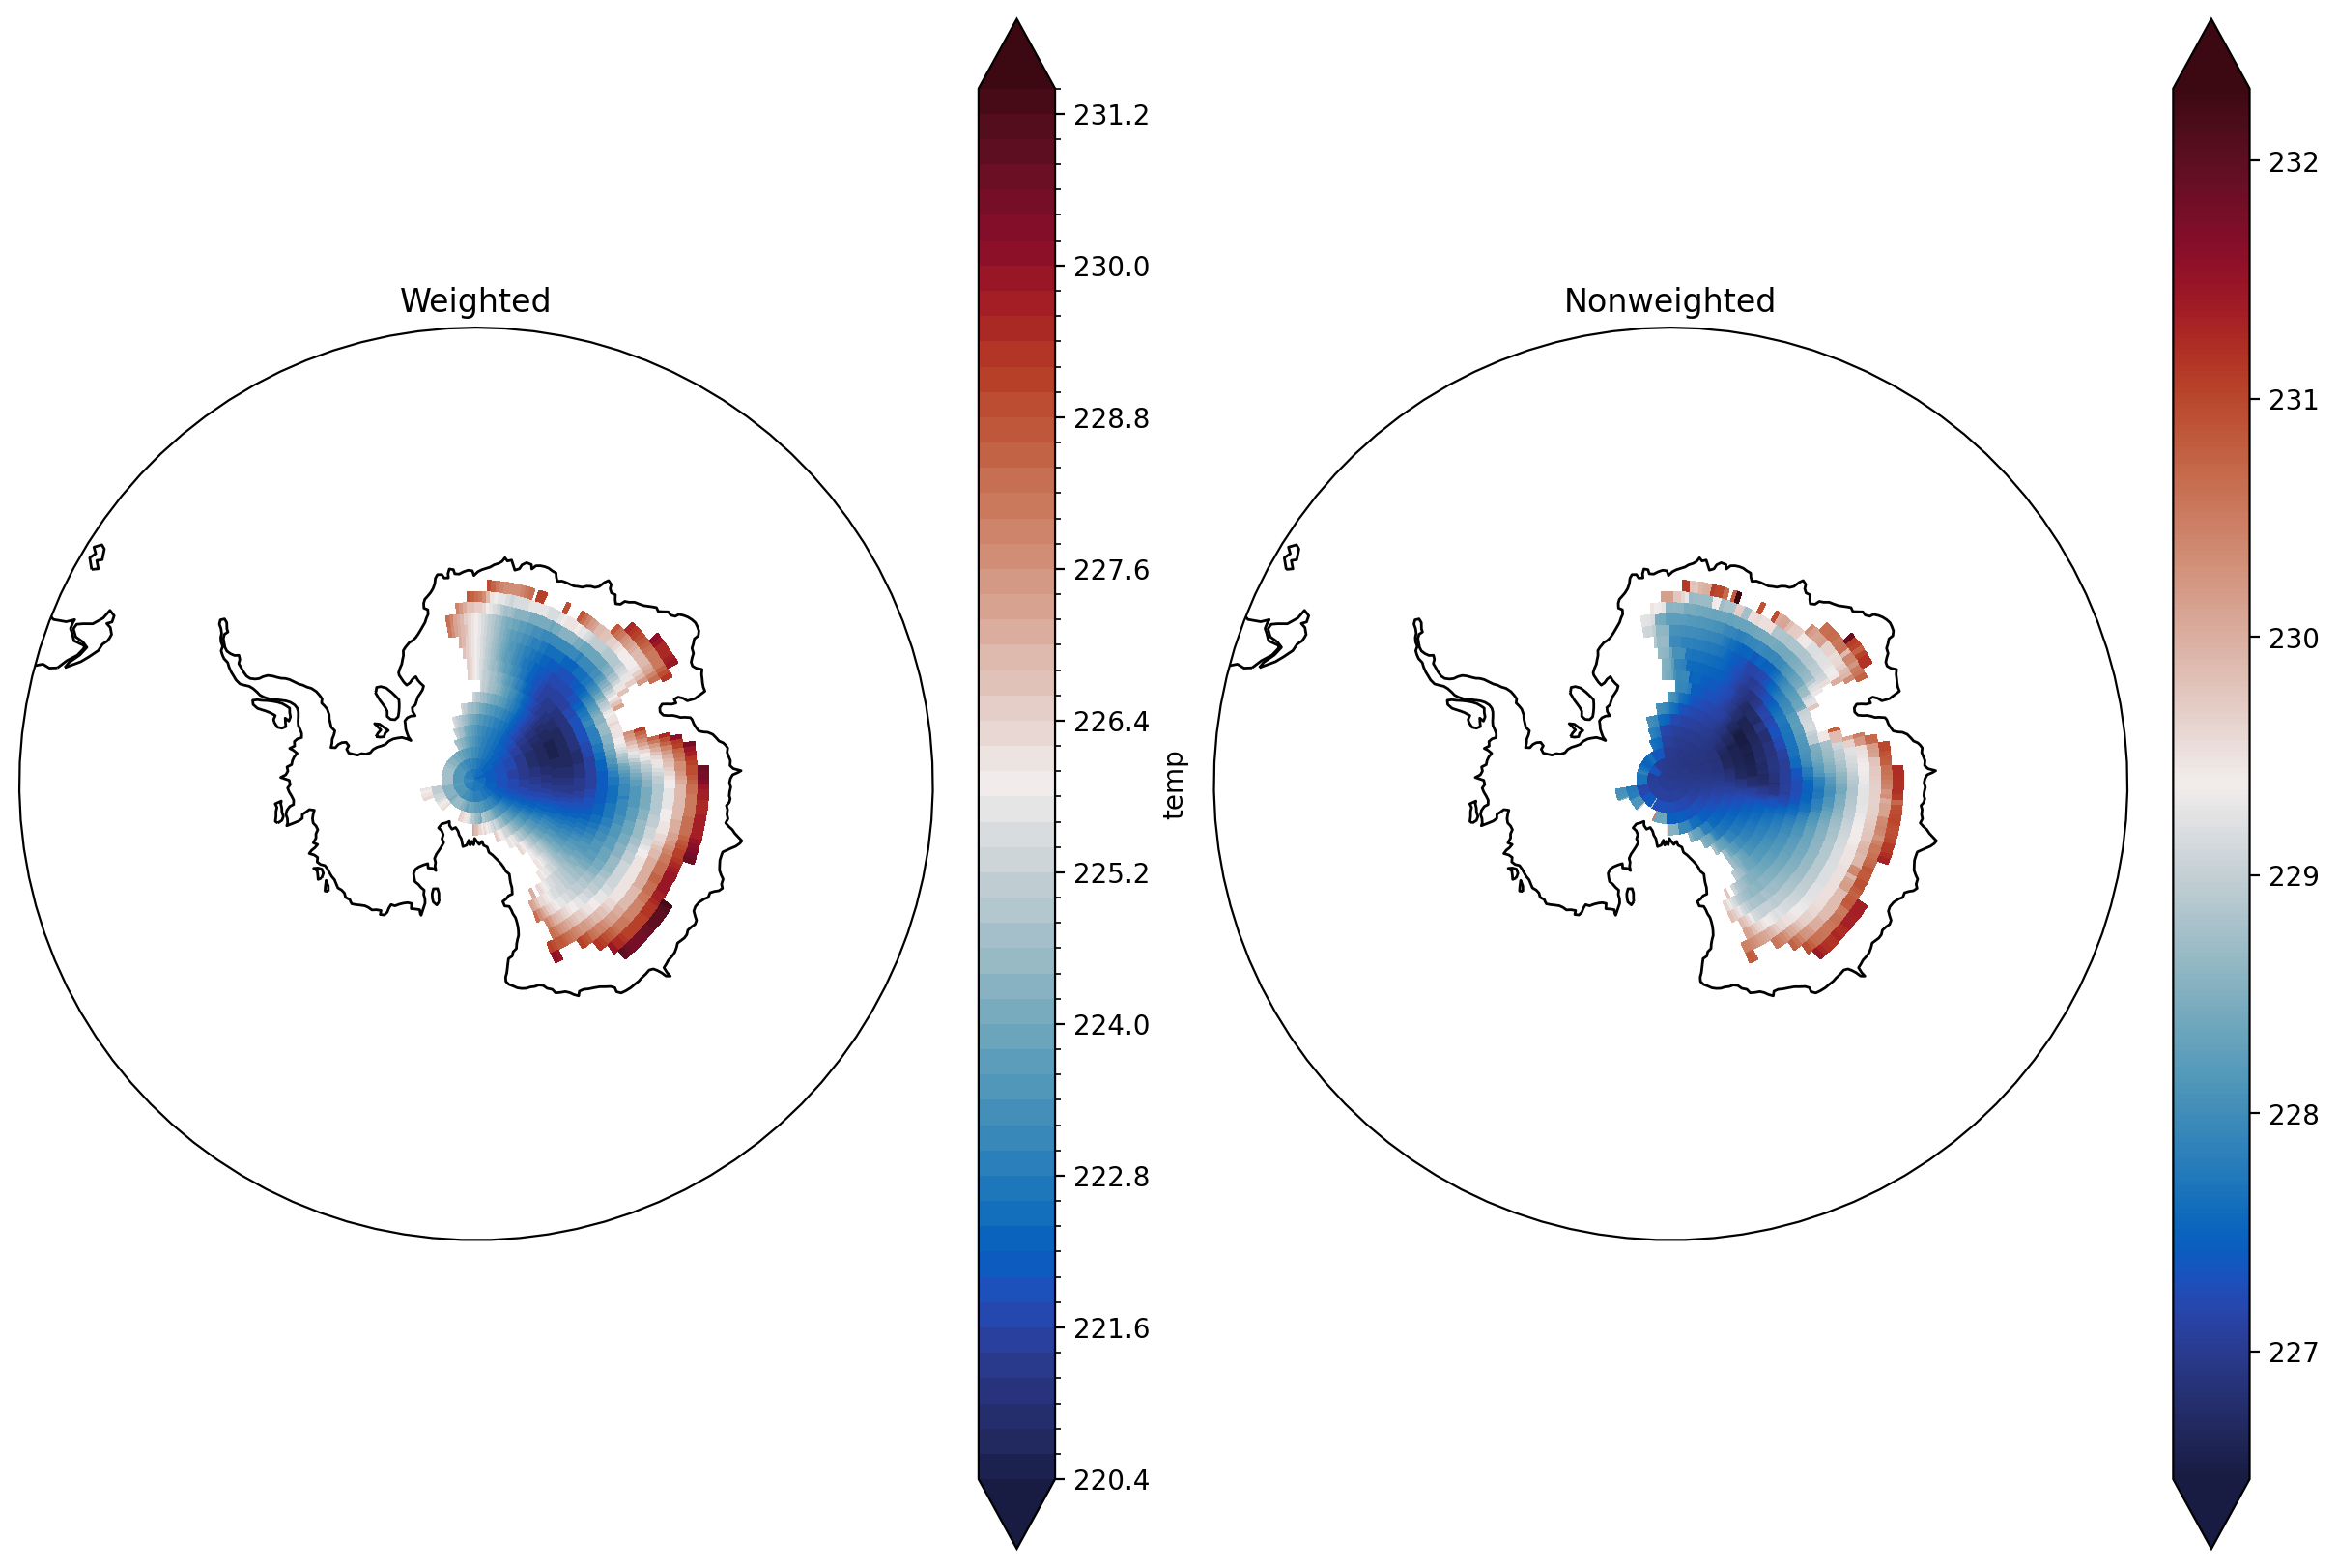

In [80]:

fig, ax = south_pole_map(cols=2, fig_size=(12,8))
    
plateau_weighted_average_temp.plot(ax=ax[0],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.balance, levels=60)

plateau_temp_total.plot(ax=ax[1],
              transform =ccrs.PlateCarree(),
        
              extend='both',
              cmap=cmocean.cm.balance)
    
   
#ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())


theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

#ax.set_boundary(circle, transform=ax.transAxes)
ax[0].coastlines()
ax[1].coastlines()
ax[0].set_title('Weighted')
ax[1].set_title('Nonweighted')

Text(0.5, 1.0, 'Nonweighted')

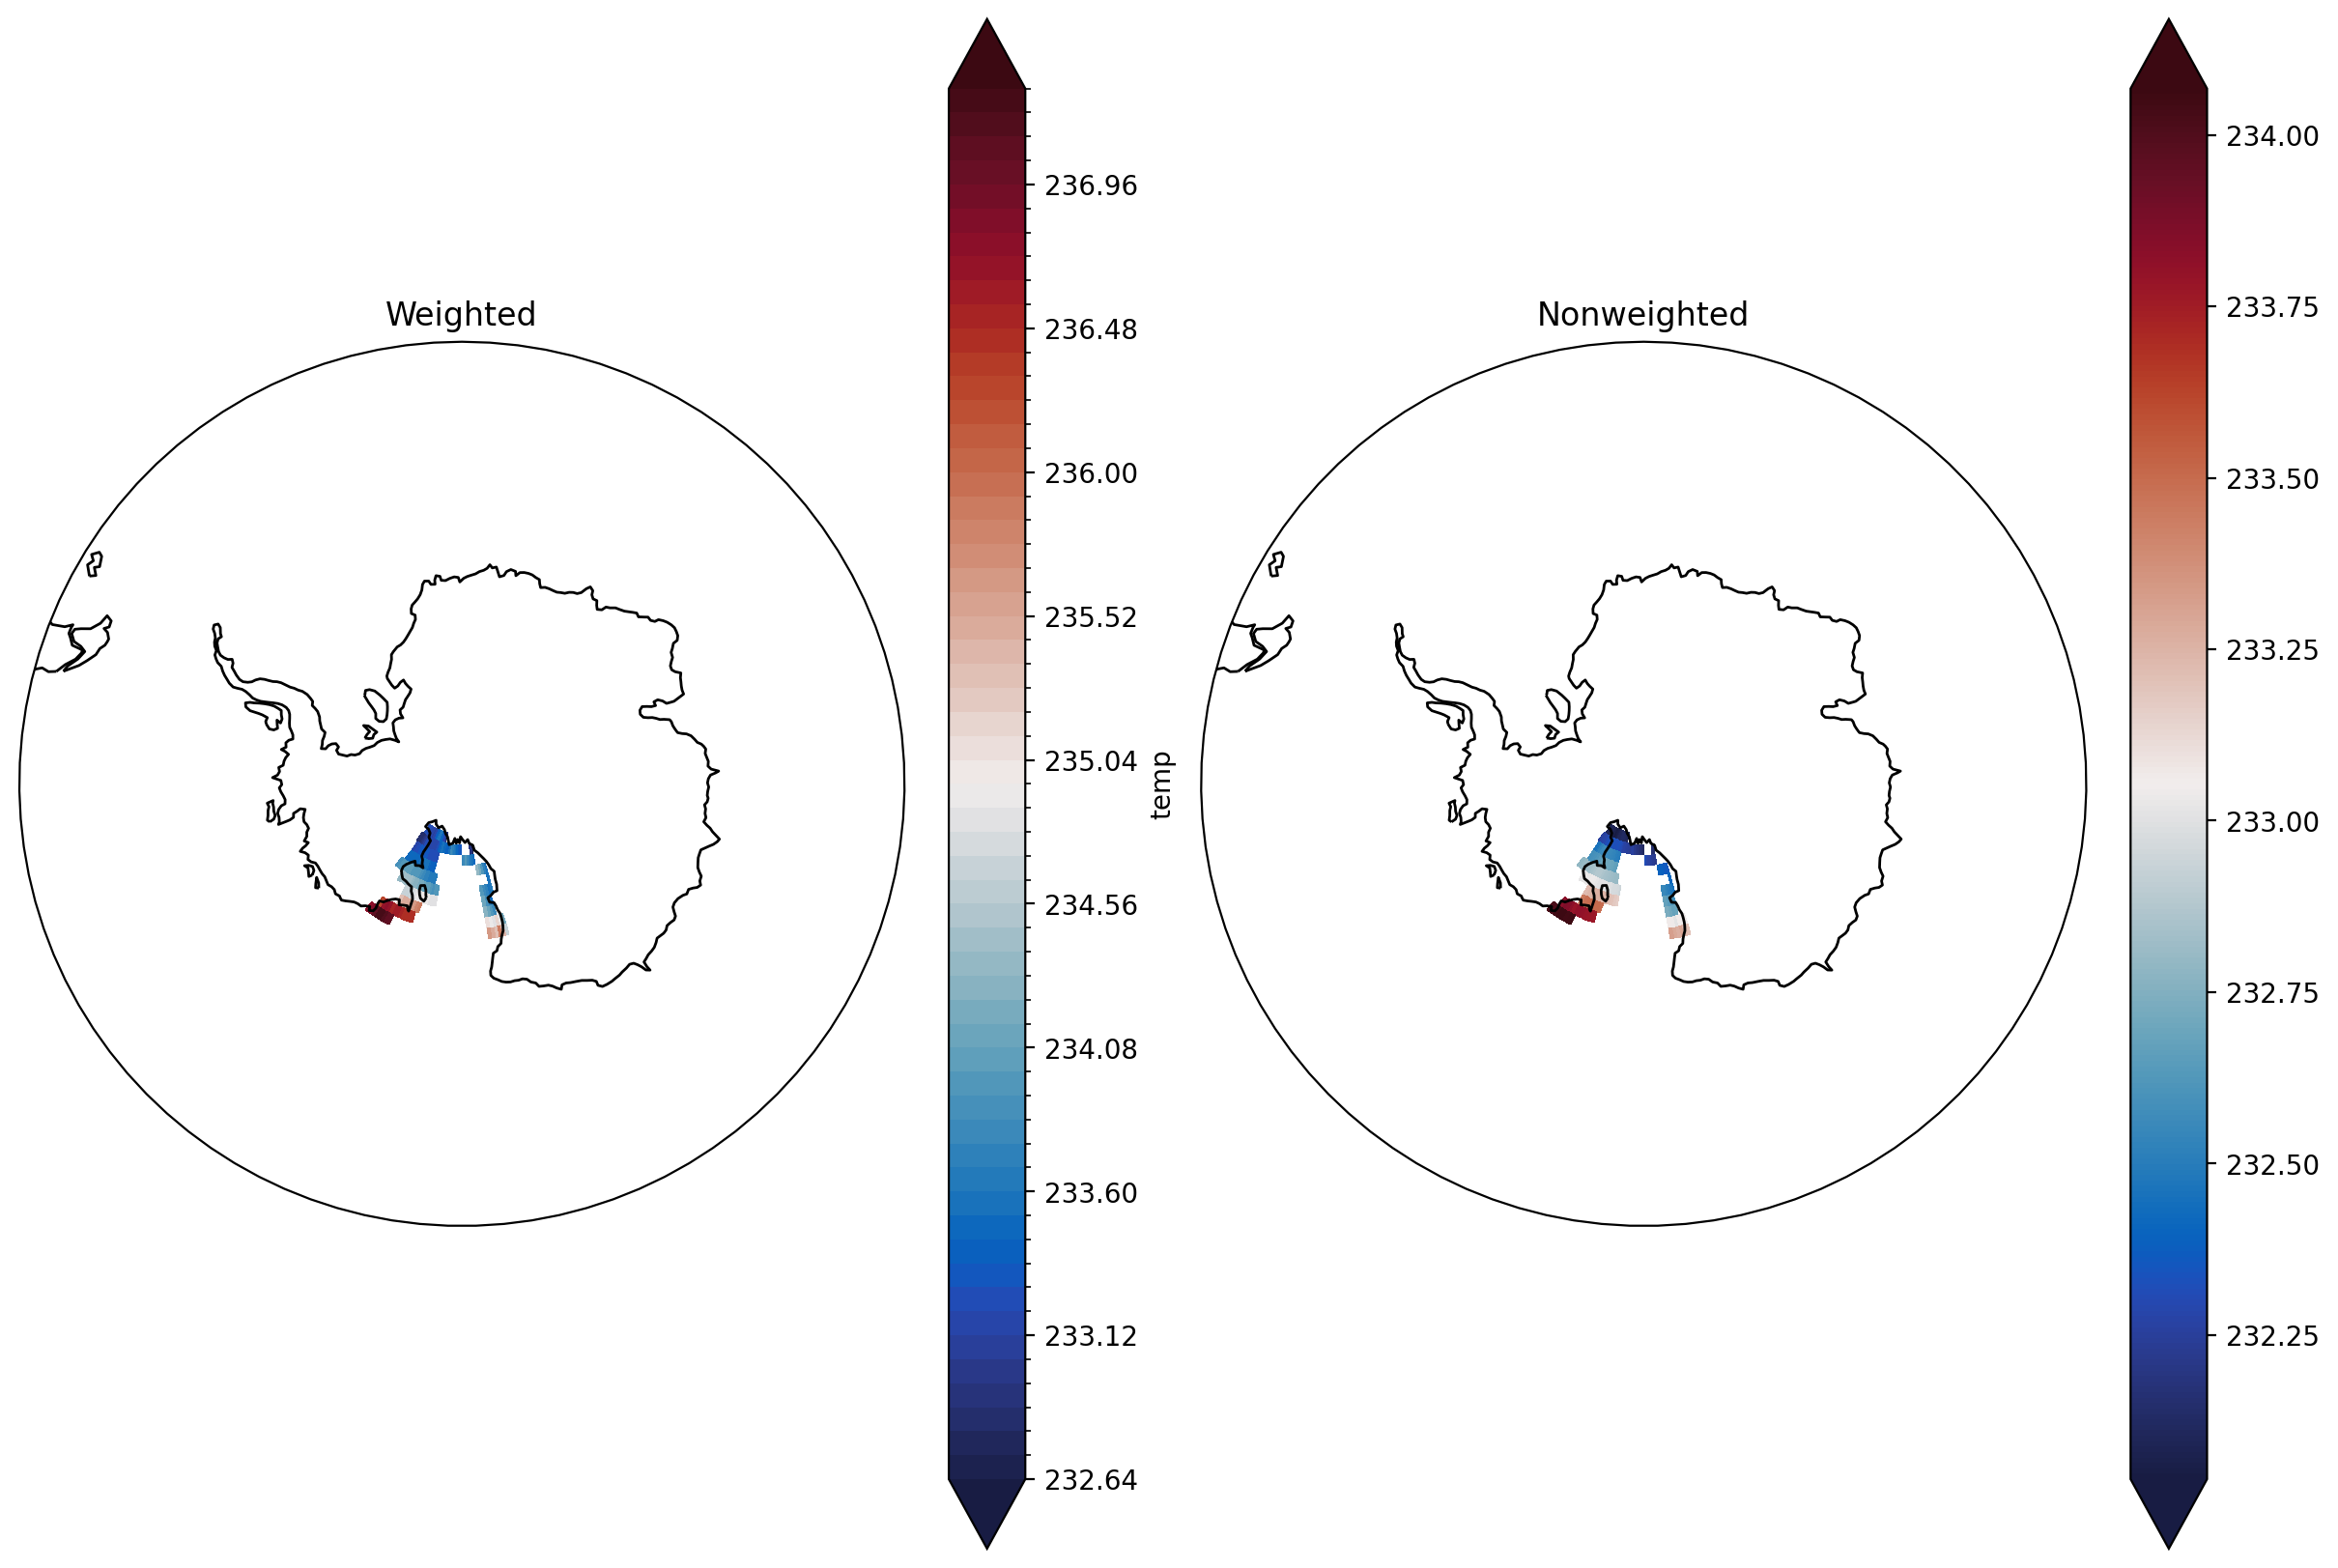

In [81]:
fig, ax = south_pole_map(cols=2, fig_size=(12,8))
    
ross_weighted_average_temp.plot(ax=ax[0],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.balance, levels=60)

ross_temp_total.plot(ax=ax[1],
              transform =ccrs.PlateCarree(),
        
              extend='both',
              cmap=cmocean.cm.balance)
    
   
#ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())


theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

#ax.set_boundary(circle, transform=ax.transAxes)
ax[0].coastlines()
ax[1].coastlines()
ax[0].set_title('Weighted')
ax[1].set_title('Nonweighted')

Text(0.5, 1.0, 'Nonweighted')

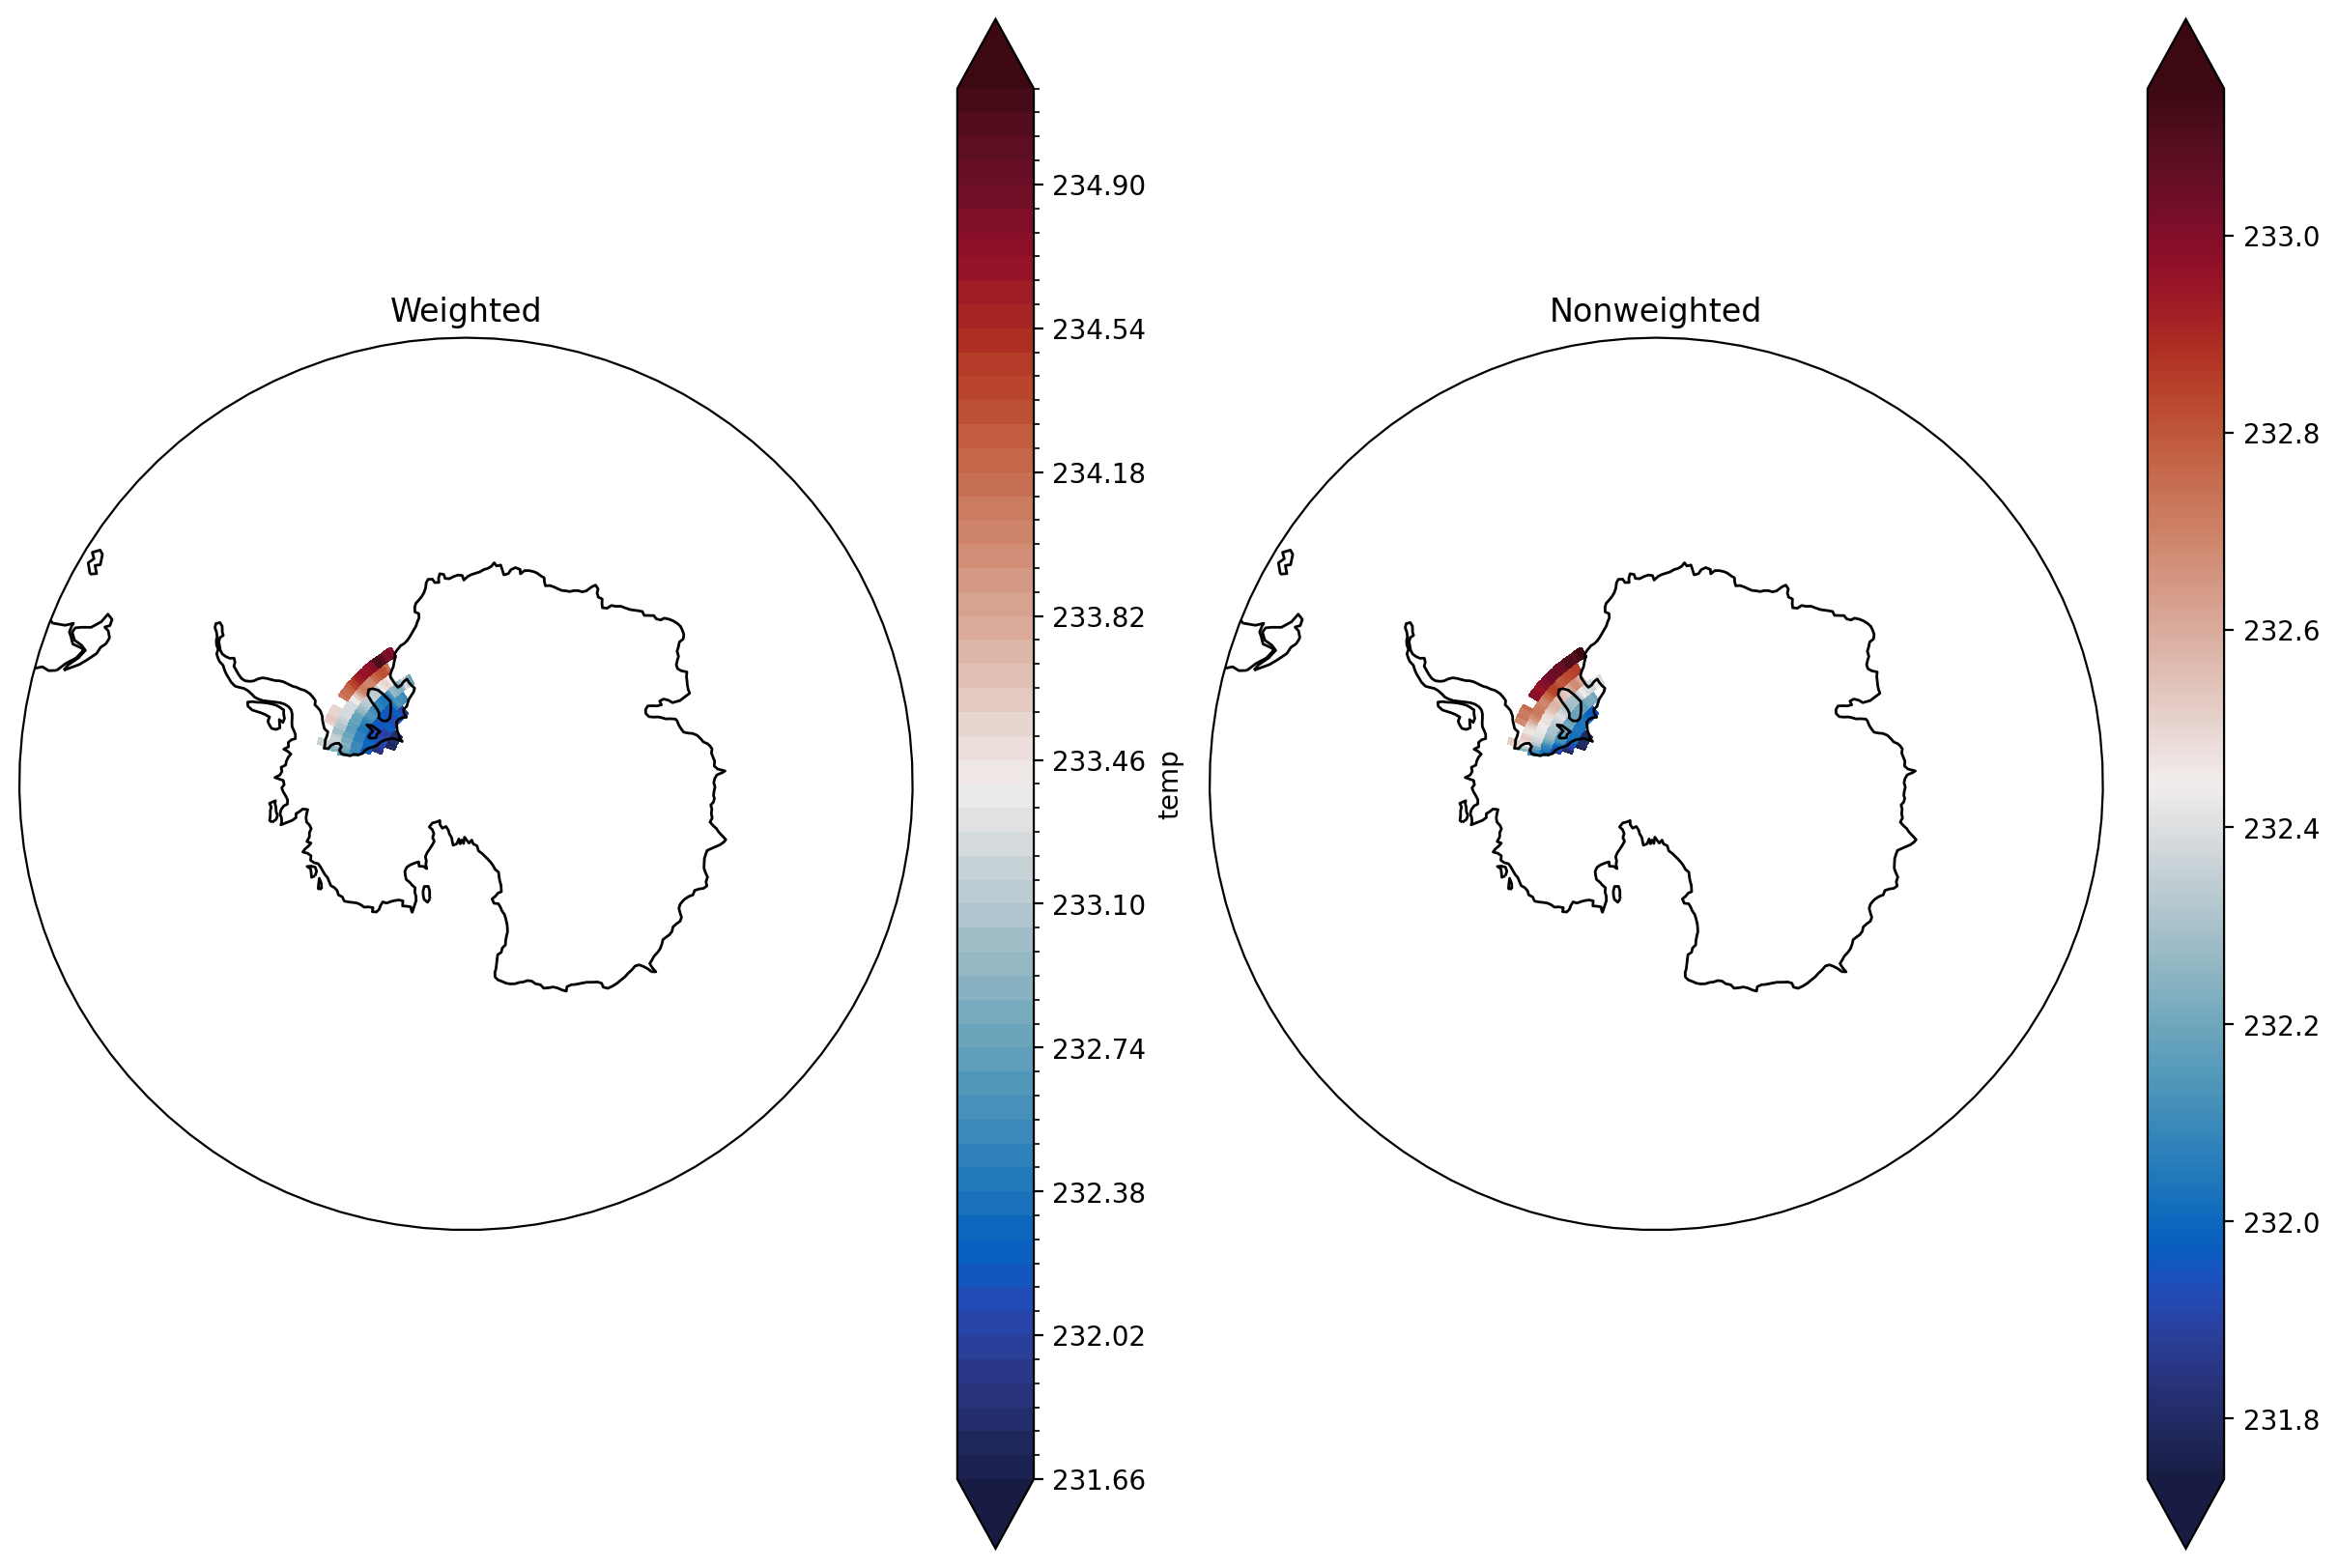

In [82]:
fig, ax = south_pole_map(cols=2, fig_size=(12,8))
    
filchner_weighted_average_temp.plot(ax=ax[0],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.balance, levels=60)

filchner_temp_total.plot(ax=ax[1],
              transform =ccrs.PlateCarree(),
        
              extend='both',
              cmap=cmocean.cm.balance)
    
   
#ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())


theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

#ax.set_boundary(circle, transform=ax.transAxes)
ax[0].coastlines()
ax[1].coastlines()
ax[0].set_title('Weighted')
ax[1].set_title('Nonweighted')

Text(0.5, 1.0, 'Nonweighted')

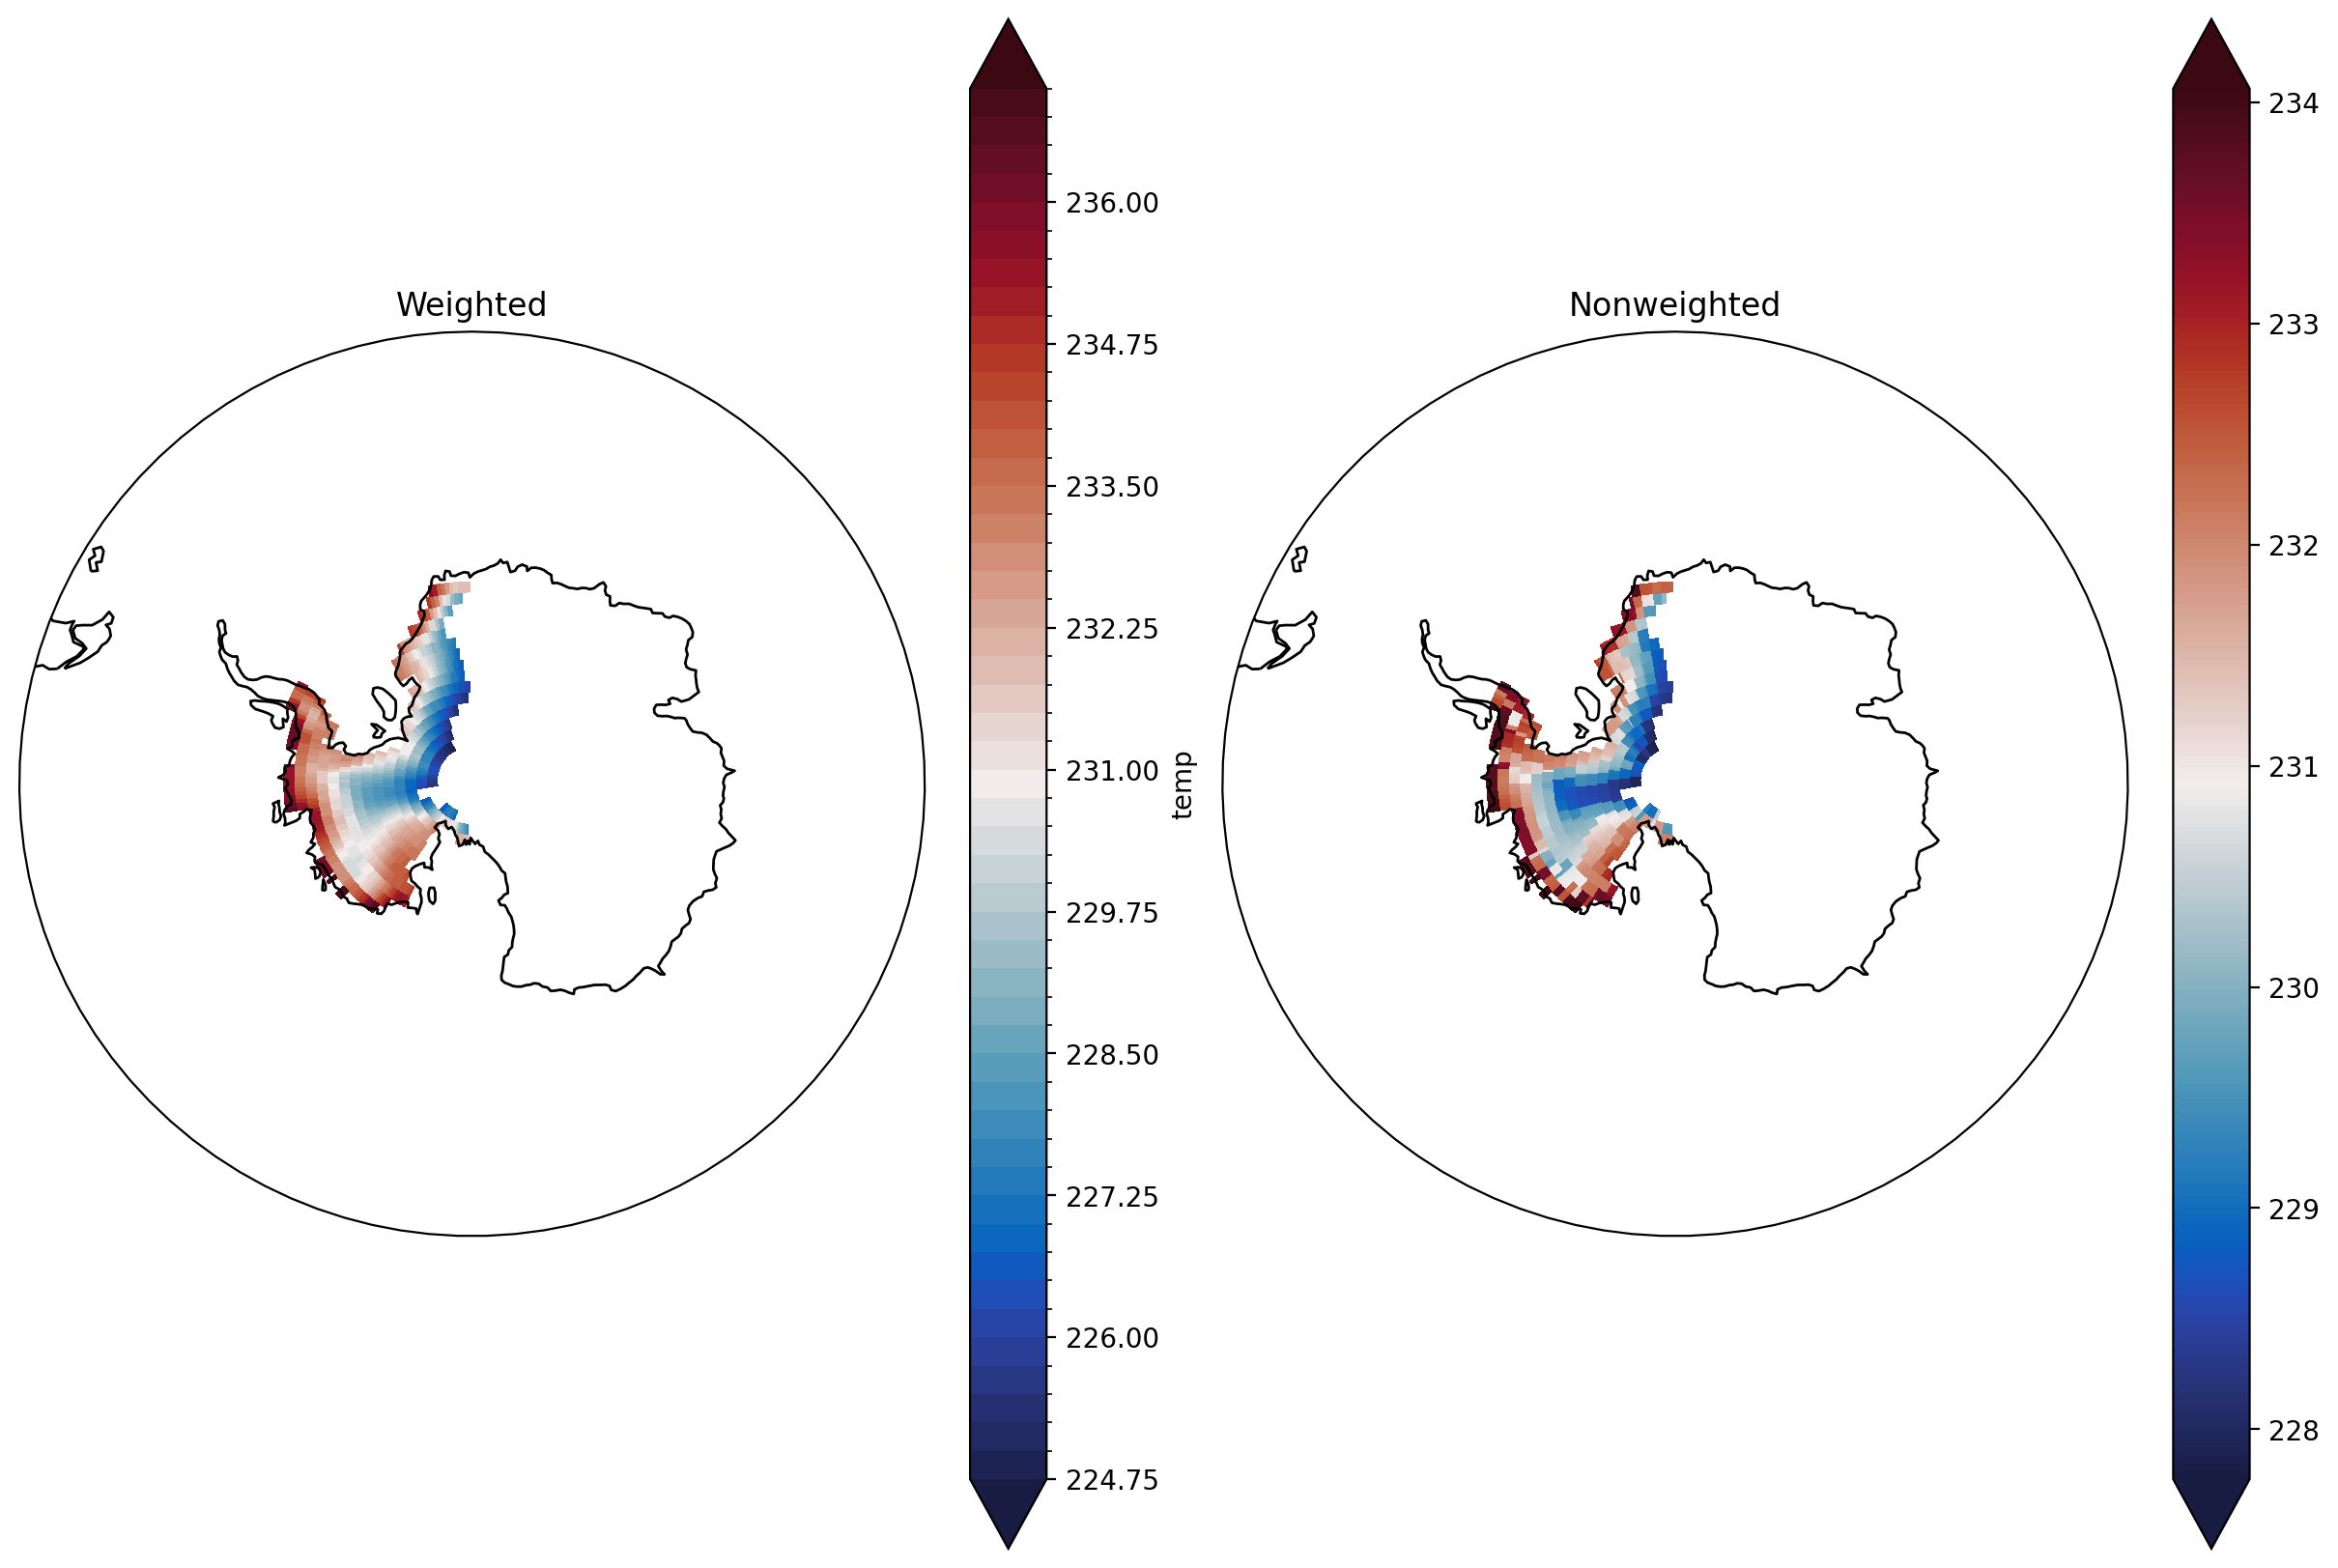

In [83]:
fig, ax = south_pole_map(cols=2, fig_size=(12,8))
    
lowwest_weighted_average_temp.plot(ax=ax[0],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.balance, levels=60)

lowwest_temp_total.plot(ax=ax[1],
              transform =ccrs.PlateCarree(),
        
              extend='both',
              cmap=cmocean.cm.balance)
    
   
#ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())


theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

#ax.set_boundary(circle, transform=ax.transAxes)
ax[0].coastlines()
ax[1].coastlines()
ax[0].set_title('Weighted')
ax[1].set_title('Nonweighted')

Text(0.5, 1.0, 'Nonweighted')

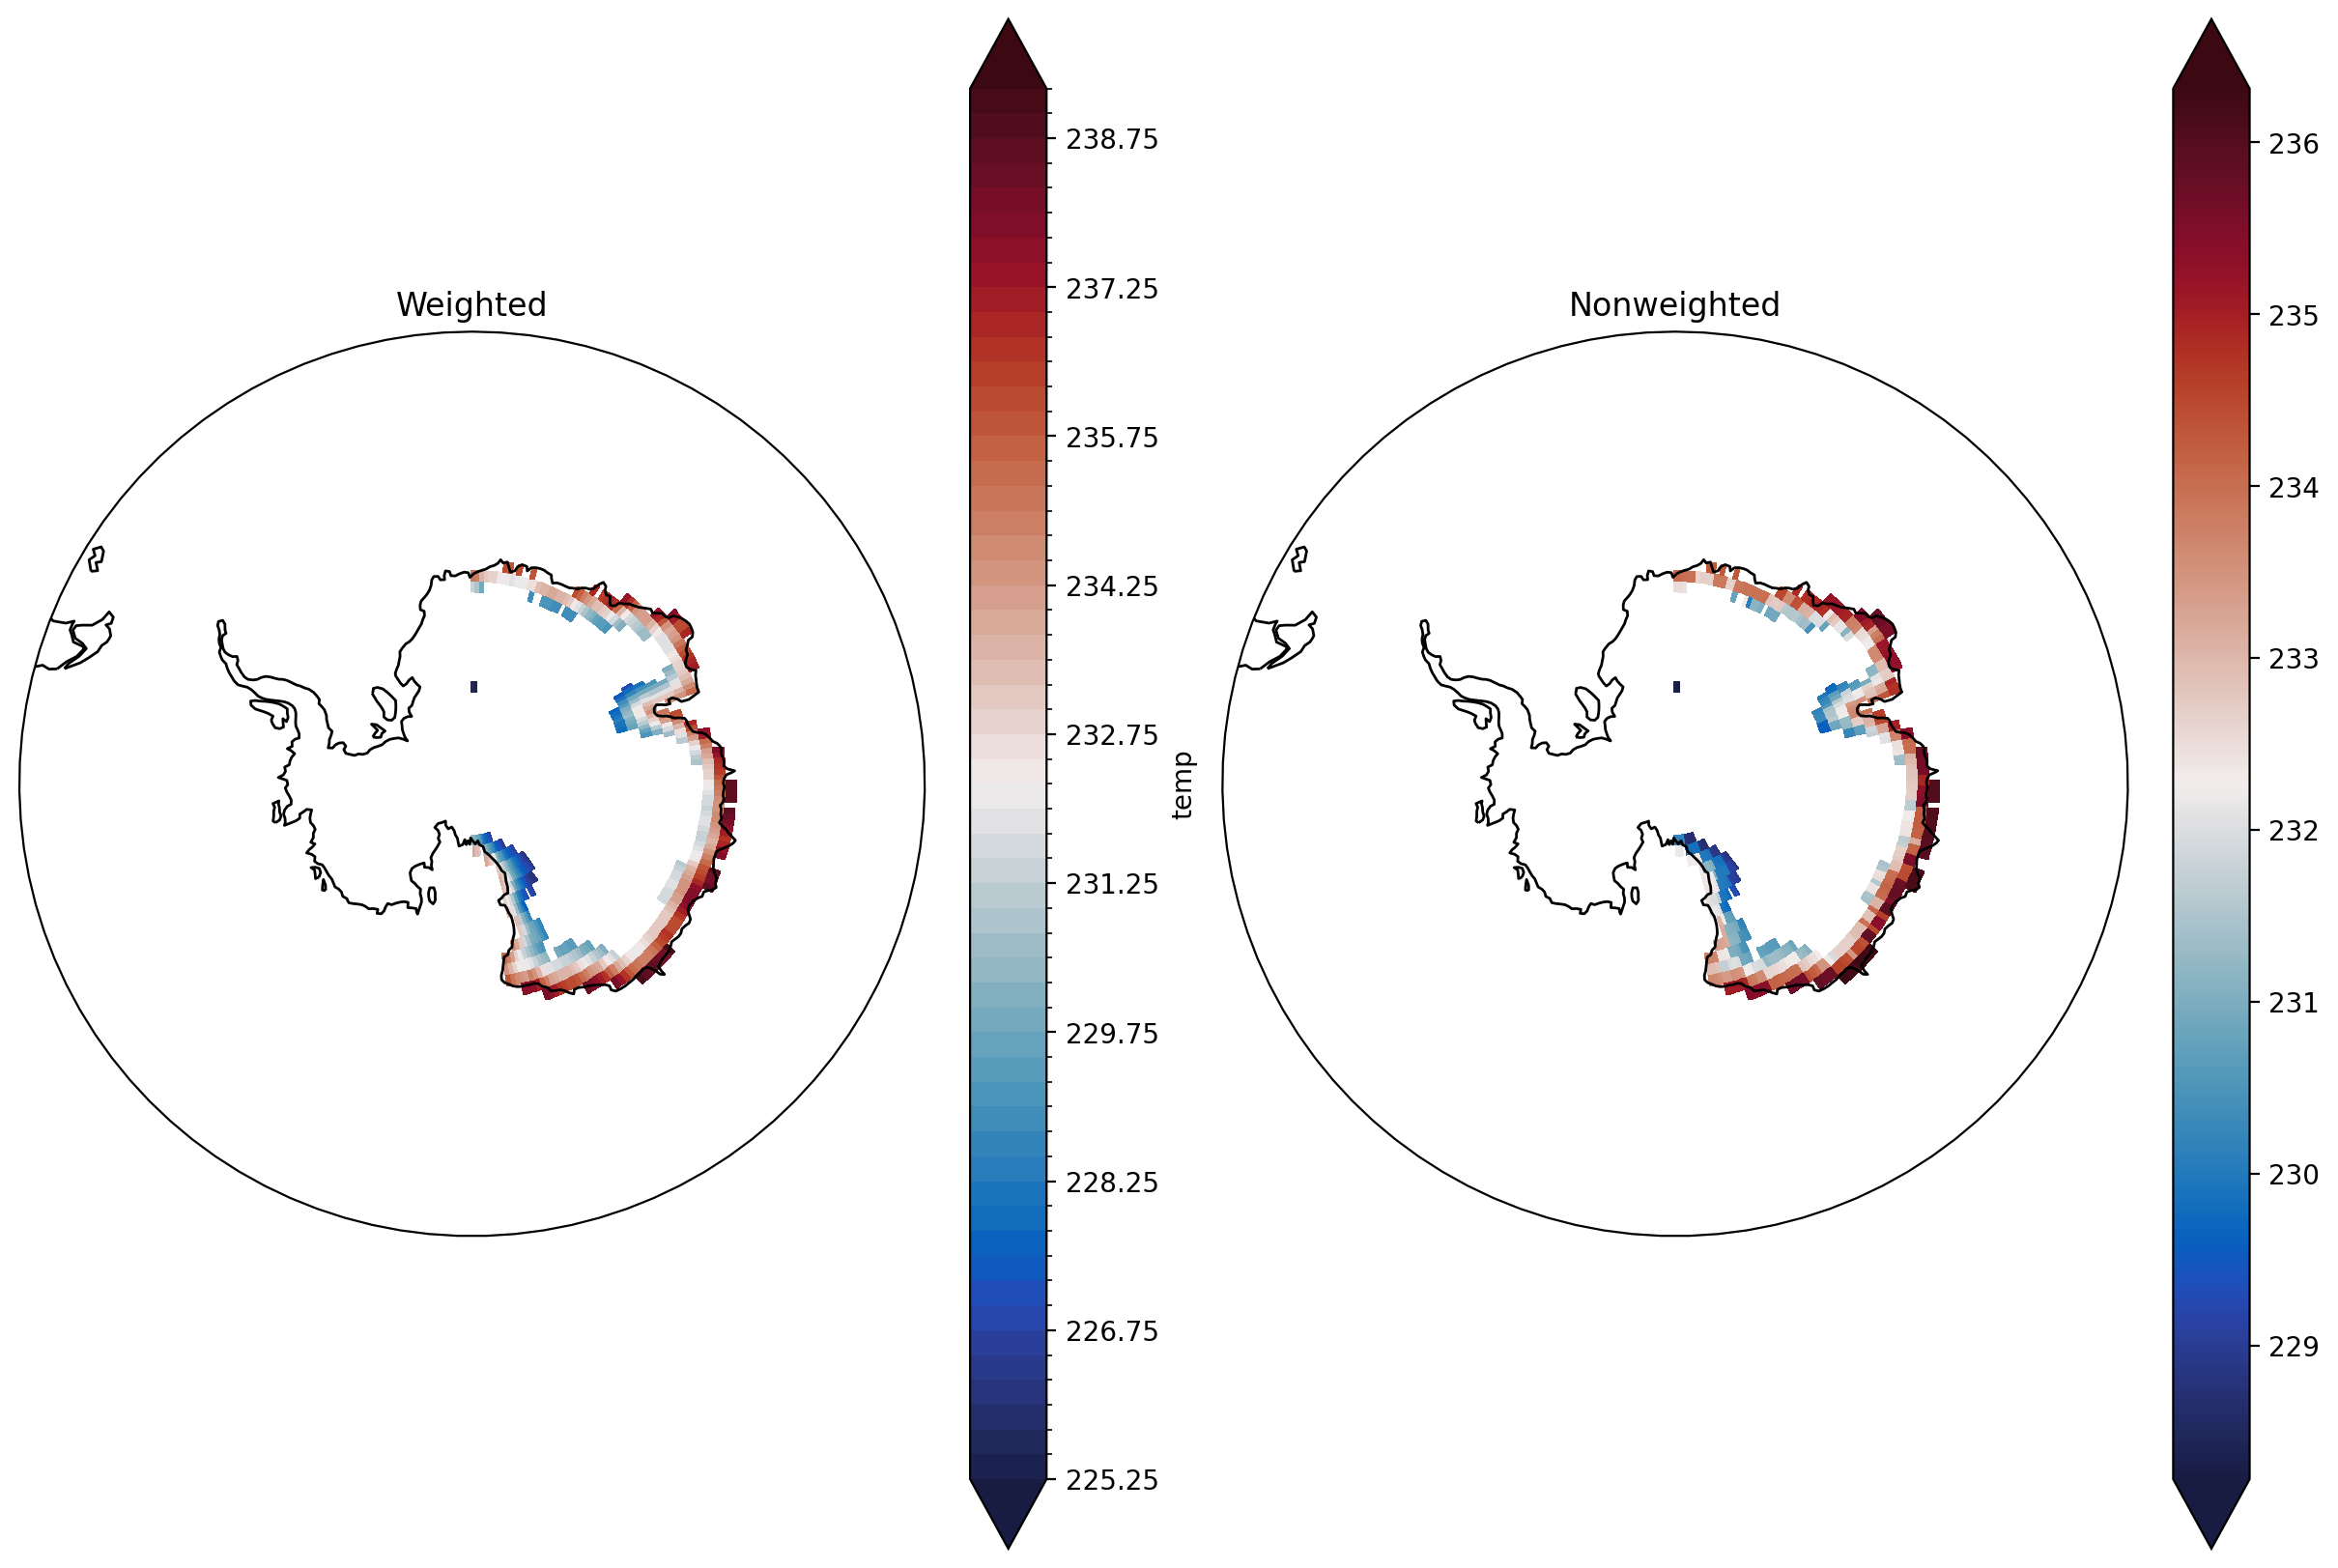

In [84]:
fig, ax = south_pole_map(cols=2, fig_size=(12,8))
    
loweast_weighted_average_temp.plot(ax=ax[0],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.balance, levels=60)

loweast_temp_total.plot(ax=ax[1],
              transform =ccrs.PlateCarree(),
        
              extend='both',
              cmap=cmocean.cm.balance)
    
   
#ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())


theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

#ax.set_boundary(circle, transform=ax.transAxes)
ax[0].coastlines()
ax[1].coastlines()
ax[0].set_title('Weighted')
ax[1].set_title('Nonweighted')

Text(0.5, 1.0, 'Nonweighted')

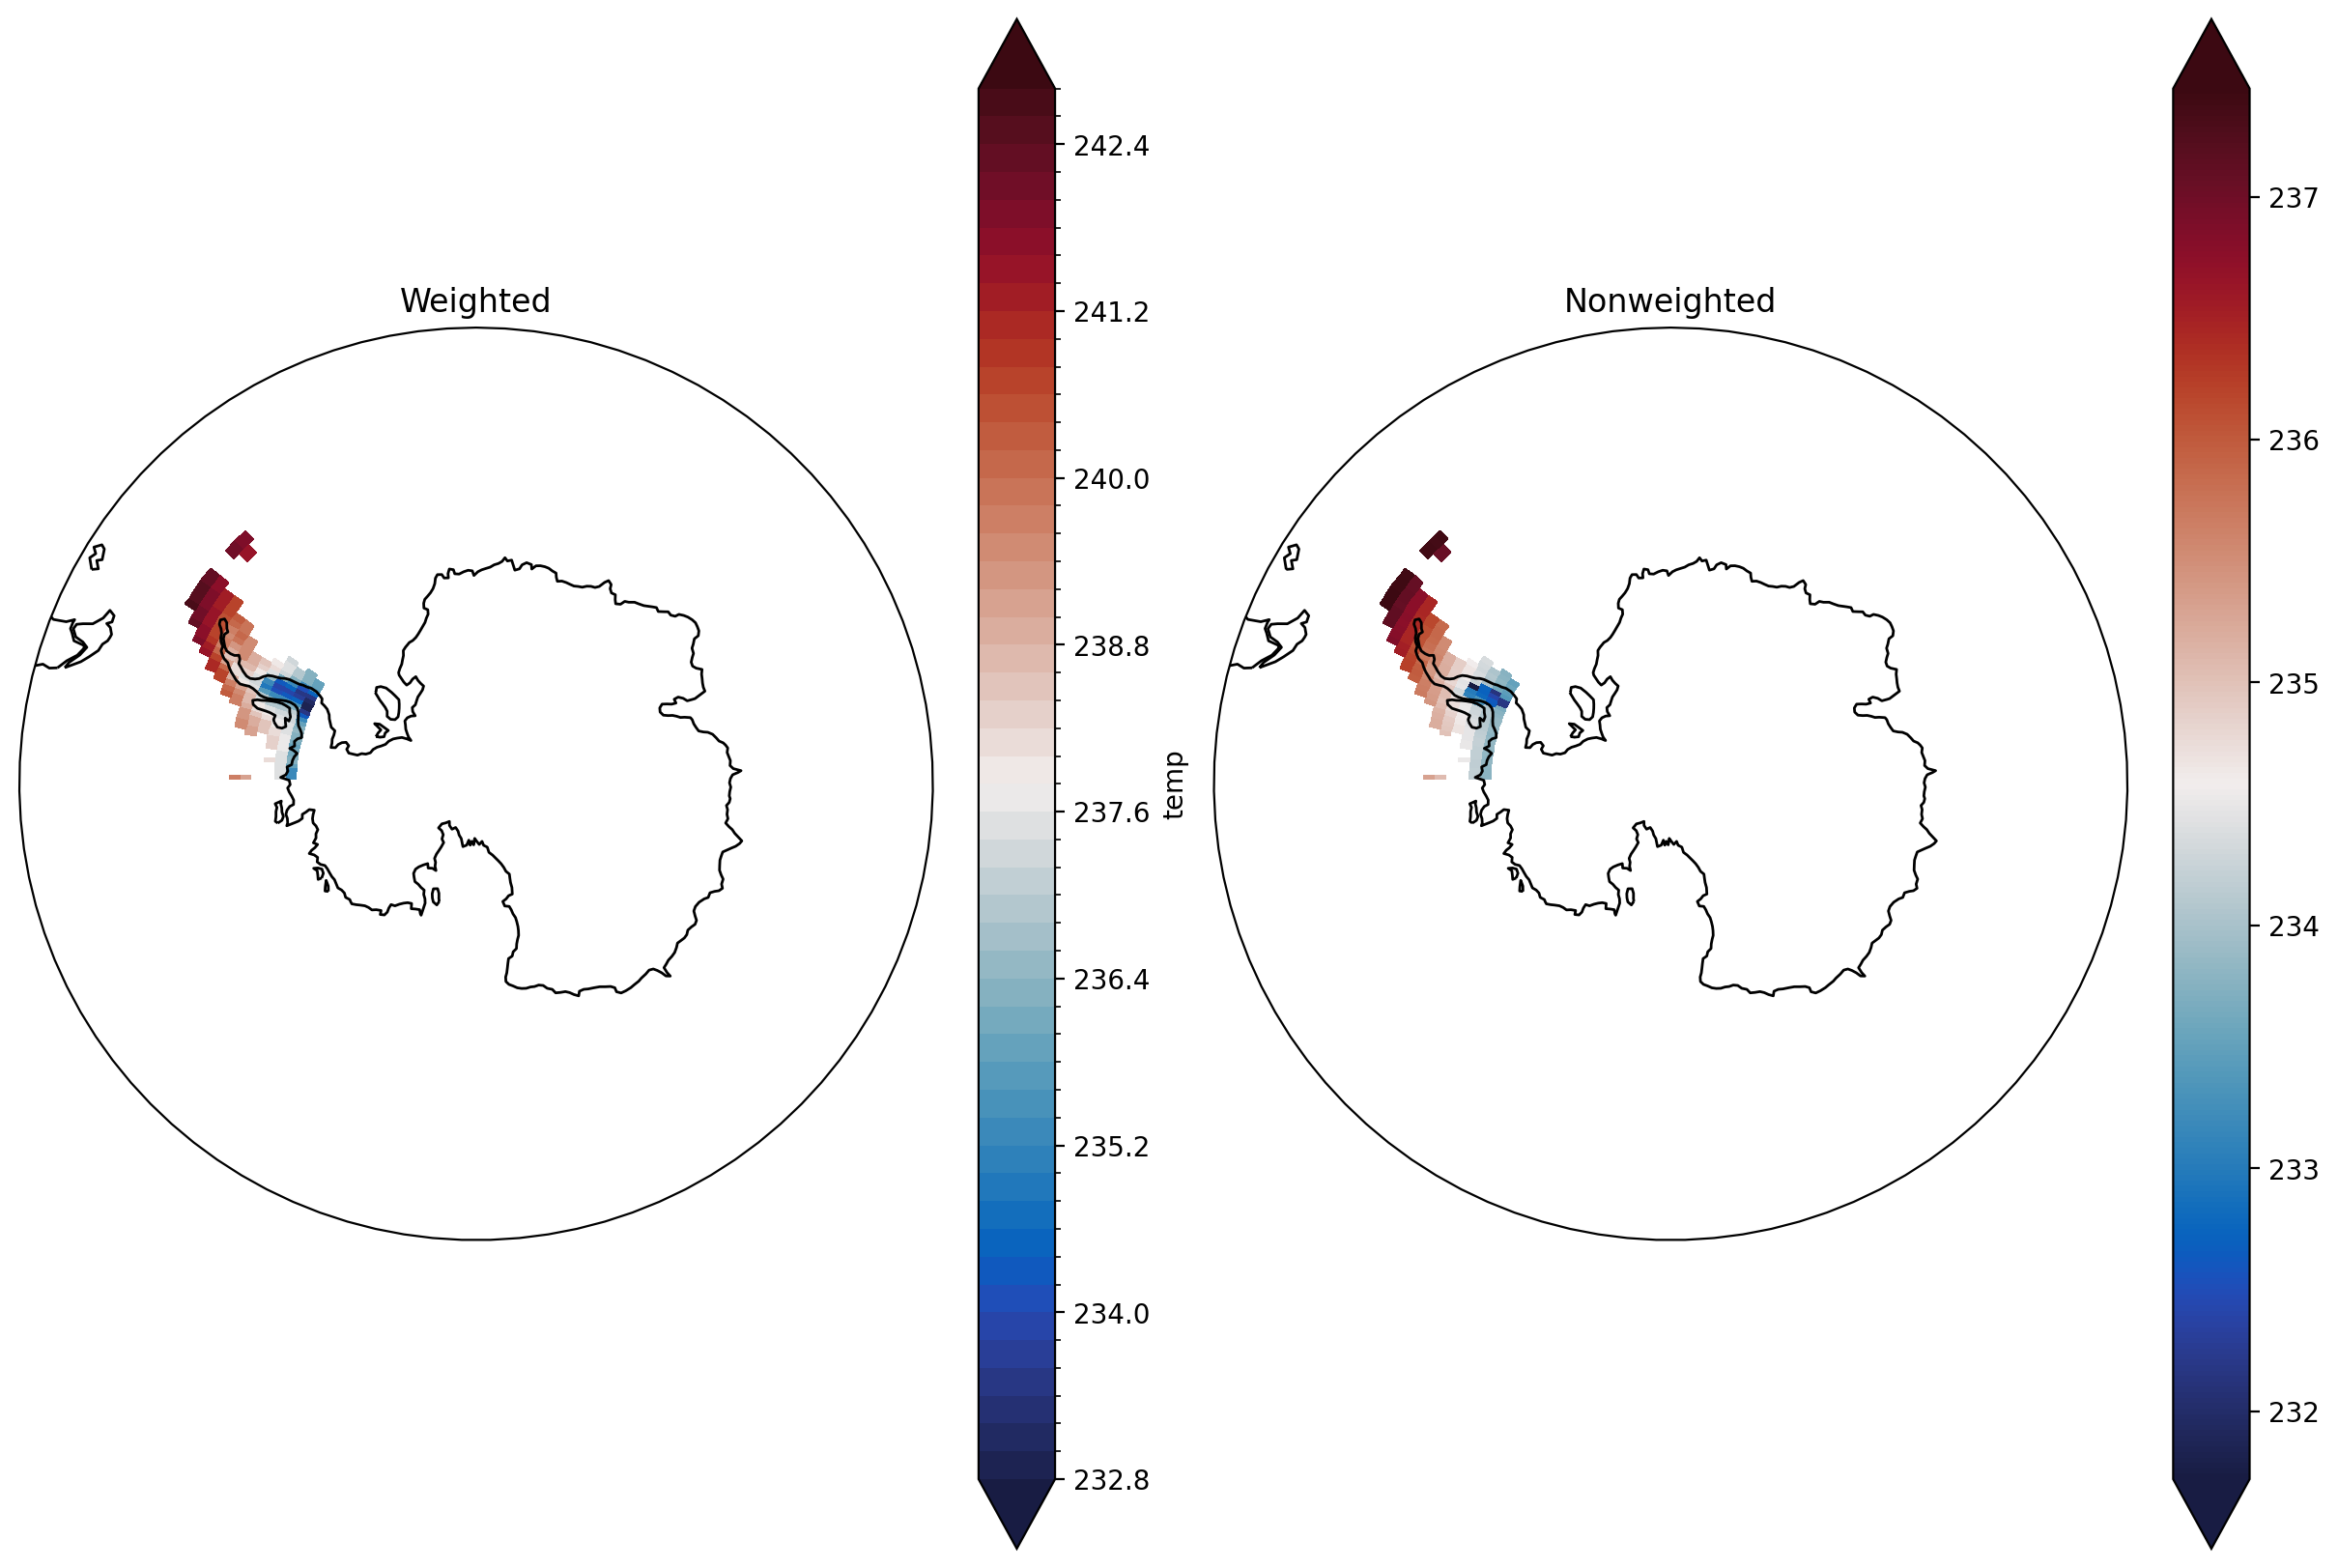

In [85]:
fig, ax = south_pole_map(cols=2, fig_size=(12,8))
    
peninsula_weighted_average_temp.plot(ax=ax[0],
               transform =ccrs.PlateCarree(),
               extend='both',
               cmap=cmocean.cm.balance, levels=60)

peninsula_temp_total.plot(ax=ax[1],
              transform =ccrs.PlateCarree(),
        
              extend='both',
              cmap=cmocean.cm.balance)
    
   
#ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())


theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

#ax.set_boundary(circle, transform=ax.transAxes)
ax[0].coastlines()
ax[1].coastlines()
ax[0].set_title('Weighted')
ax[1].set_title('Nonweighted')